In [490]:
import pandas as pd
import seaborn as sns
import csv
import matplotlib.pyplot as plt
from prophet import Prophet
%matplotlib inline
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sktime.utils.plotting import plot_series

In [491]:
from distutils.command.install import install
import datetime 
from datetime import timedelta
import matplotlib.pyplot as plt
import warnings
import  scipy.signal.signaltools
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.arima import AutoARIMA
from IPython.display import display_html
from itertools import chain,cycle
from darts.models import Theta, FourTheta, TBATS
from darts.metrics import mape
from darts import TimeSeries
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode
mse=MeanSquaredError()
rmse = MeanSquaredError(square_root=True)
from darts.metrics import mape as mape_theta,mae as mae_theta,rmse as rmse_theta,mse as mse_theta
import matplotlib.dates as mdates
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# 1. Predicción Gas Natural

In [492]:
gasn = pd.read_csv('data_materias_eur/GAS-EUR.csv')

In [493]:
gasn = gasn.drop(columns=['Open','High', 'Low', 'Adj Close', 'Volume' ])  #eliminamos columnas innecesarias

gasn['Date'] = pd.to_datetime(gasn['Date'])  #convertimos a fecha

In [494]:

gasn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1976 entries, 0 to 1975
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1976 non-null   datetime64[ns]
 1   Close   1976 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.0 KB


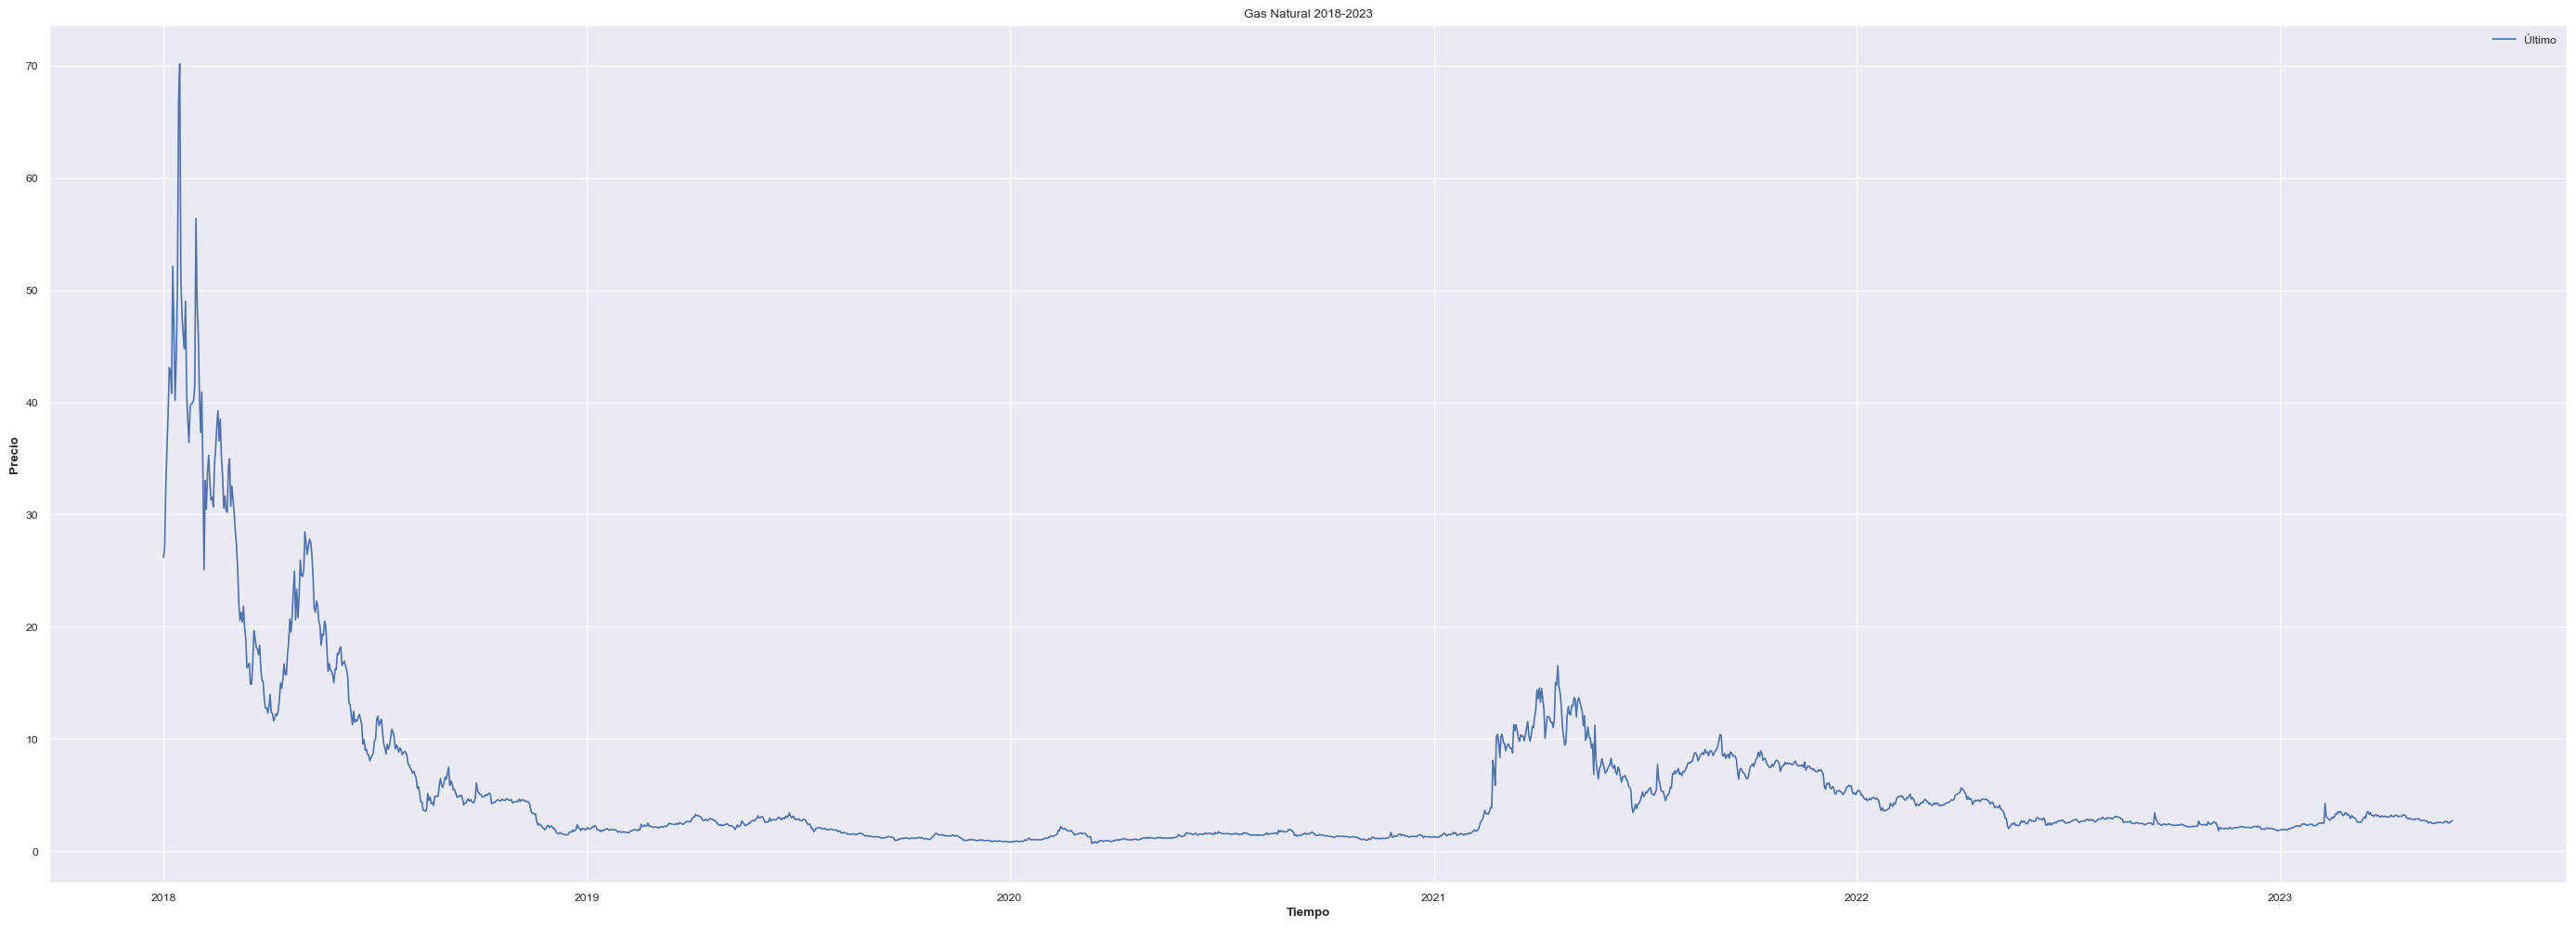

In [495]:
fig = plt.figure(figsize=(35,12))
sns.set_style("darkgrid")

sns.lineplot(x=gasn.Date,y=gasn['Close'], data=gasn['Close'])

plt.title('Gas Natural 2018-2023')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend(['Último'])

plt.show()

Relleno los fines de semana

In [496]:
import datetime

In [497]:
gasn = gasn.set_index('Date')
date_range = pd.date_range(start=gasn.index.min(), end=gasn.index.max())
filled_gasn = pd.merge(pd.DataFrame(date_range, columns=['Date']), gasn, how='left', left_on='Date', right_index=True)

filled_gasn = filled_gasn.fillna(method='ffill')



In [498]:
filled_gasn.head()

Date      Close
0 2018-01-01  26.183029
1 2018-01-02  27.124121
2 2018-01-03  32.633389
3 2018-01-04  35.773663
4 2018-01-05  39.078068

1.1. Test DickeyFuller

In [499]:
from statsmodels.tsa.stattools import adfuller

y = filled_gasn.Close
result = adfuller(y)
print('Dickey-Fuller Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Dickey-Fuller Statistic: -5.452756
p-value: 0.000003
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Dickey-Fuller me dice que es estacionaria por lo tanto se debería poder hacer el modelo con ARIMA 

1.2. Preparación datos

Sacarme columna de año mes y dia

In [500]:
filled_gasn['year'] = filled_gasn['Date'].dt.year
filled_gasn['month'] = filled_gasn['Date'].dt.month
filled_gasn['day'] = filled_gasn['Date'].dt.day

filled_gasn.isnull().sum()

Date     0
Close    0
year     0
month    0
day      0
dtype: int64

Sacar X e y

In [501]:
x = filled_gasn.iloc[:, -3:].values  #input
y = filled_gasn.iloc[:, 1].values #output price only

In [502]:
filled_gasn.tail(4)

Date     Close  year  month  day
1972 2023-05-27  2.505847  2023      5   27
1973 2023-05-28  2.587448  2023      5   28
1974 2023-05-29  2.688613  2023      5   29
1975 2023-05-30  2.700953  2023      5   30

In [503]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=5,shuffle=False)

y_test

array([2.545363, 2.505847, 2.587448, 2.688613, 2.700953])

### Decision Tree Regressor

In [504]:
#import decision tree regressor
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor()
#fitting the model or training the model
dtr.fit(x_train,y_train)

DecisionTreeRegressor()

In [505]:
y_pred=dtr.predict(x_test)
y_pred;

In [506]:
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,y_pred)
accuracy

-0.5628005507575704

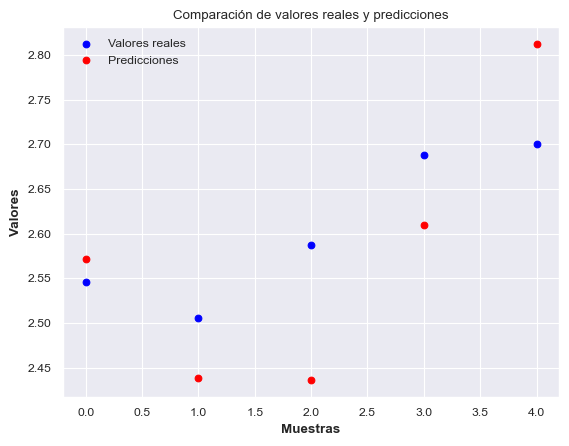

In [507]:
# gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores reales')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Comparación de valores reales y predicciones')
plt.legend()
plt.show()

In [508]:
y_test

array([2.545363, 2.505847, 2.587448, 2.688613, 2.700953])

XGBOOST

XGBRegressor (XGBR): XGBR es una implementación del algoritmo de refuerzo llamado Extreme Gradient Boosting (XGBoost). Es similar a GBR, pero utiliza una técnica de refuerzo mejorada y optimizaciones adicionales para lograr un rendimiento más rápido y preciso. XGBoost ha demostrado ser eficaz en una amplia gama de problemas de aprendizaje automático y es ampliamente utilizado en competencias de Kaggle.



XGBRegressor(n_estimators=100)

In [509]:
from xgboost import XGBRegressor as XGBR

In [510]:
xgbr=XGBR()
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [511]:
y_pred=xgbr.predict(x_test)

mean_squared_error(y_test, y_pred, squared=False)  # RMSE

0.1258590053674676

In [512]:
x_test

array([[2023,    5,   26],
       [2023,    5,   27],
       [2023,    5,   28],
       [2023,    5,   29],
       [2023,    5,   30]], dtype=int64)

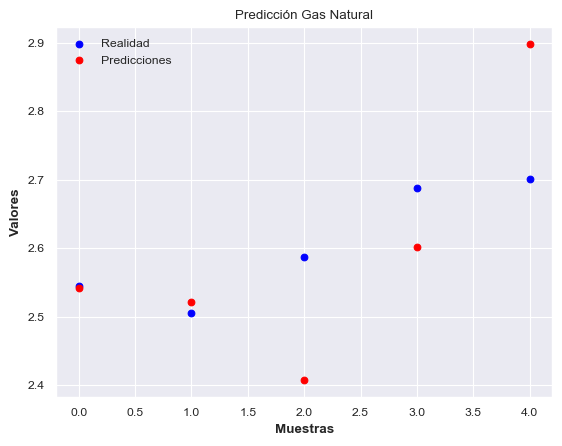

In [513]:
# gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Realidad')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Predicción Gas Natural')
plt.legend()
plt.show()

 ### Predicciones para los próximos 10 días

In [514]:
last_date = pd.to_datetime(filled_gasn['Date'].iloc[-1])
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=10)
x_next_7_days = np.array([next_dates.year, next_dates.month, next_dates.day]).T

In [515]:
y_pred

array([2.5421007, 2.5208519, 2.407091 , 2.6019254, 2.8982427],
      dtype=float32)

In [516]:
gasn_pred=xgbr.predict(x_next_7_days)

In [517]:
gasn_pred_df = pd.DataFrame({'Date': next_dates, 'GasN_pred': gasn_pred})
gasn_pred_df


Date  GasN_pred
0 2023-05-31   2.805192
1 2023-06-01   2.061391
2 2023-06-02   1.999522
3 2023-06-03   1.976082
4 2023-06-04   2.064189
5 2023-06-05   2.243734
6 2023-06-06   2.354160
7 2023-06-07   2.332626
8 2023-06-08   2.402037
9 2023-06-09   2.464789

## ARIMA

In [518]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt


#poner el limite de división

fecha = pd.to_datetime('2023-05-24')
index = filled_gasn[filled_gasn['Date'] <= fecha]['Date'].idxmax()

#Dividir en conjuntos de entrenamiento y prueba
train_gasn = filled_gasn[:index]
test_gasn = filled_gasn[index:]



## SARIMA

En el caso de SARIMAX, los parámetros order se refieren a la componente no estacional del modelo, mientras que seasonal_order se refiere a la componente estacional del modelo.

El parámetro order se especifica como (p, d, q), donde:

- p es el orden del componente autoregresivo (AR). Representa la dependencia lineal de la variable con sus valores pasados. Un valor típico podría ser 1 o 2.

- d es el orden de diferenciación. Representa la cantidad de veces que se deben tomar diferencias para hacer que los datos sean estacionarios. Si los datos ya son estacionarios, d=0. En caso contrario, se puede probar con d=1 o d=2 para eliminar tendencias o patrones de crecimiento.

- q es el orden del componente de promedio móvil (MA). Representa la dependencia lineal de la variable con los errores pasados. Un valor típico podría ser 1 o 2.

El parámetro seasonal_order se especifica como (P, D, Q, S), donde:

- P es el orden del componente estacional autoregresivo (SAR). Captura la dependencia lineal de la variable con sus valores pasados en un período estacional.

- D es el orden de diferenciación estacional. Representa la cantidad de veces que se deben tomar diferencias estacionales para hacer que los datos sean estacionarios.

- Q es el orden del componente estacional de promedio móvil (SMA). Captura la dependencia lineal de la variable con los errores pasados en un período estacional.

- S es la longitud de la estacionalidad, es decir, la cantidad de periodos en una estación completa. Por ejemplo, si los datos tienen una estacionalidad anual, S=12 para datos mensuales.

In [519]:
'''
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA con un paso de tiempo diario
model = SARIMAX(train_gasn['Close'], order=(1, 1, 1), seasonal_order=(150, 0, 1, 7))
model_fit = model.fit()

# predicciones en el conjunto de prueba
predictions = model_fit.predict(start=index, end=len(filled_gasn)-1, dynamic=False)

# Calcular el error cuadrático medio (RMSE)
rmse = mean_squared_error(test_gasn['Close'], predictions, squared=False)
print('Test RMSE: %.3f' % rmse)

# Graficar las predicciones contra los valores reales

# Establecer el estilo y el contexto de Seaborn
sns.set(style='darkgrid', context='paper')

# Crear una figura con un tamaño personalizado
plt.figure(figsize=(10, 6))

# Tramar el conjunto de prueba y las predicciones
sns.lineplot(data=test_gasn['Close'], color='blue')
sns.lineplot(data=predictions, color='red')

plt.title('Predicciones vs. Conjunto de prueba')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.legend(['Conjunto de prueba', 'Predicciones'])

plt.tight_layout()  # Ajustar el espaciado de los elementos del gráfico
plt.show()
'''

"\nfrom statsmodels.tsa.statespace.sarimax import SARIMAX\n\n# Ajustar el modelo SARIMA con un paso de tiempo diario\nmodel = SARIMAX(train_gasn['Close'], order=(1, 1, 1), seasonal_order=(150, 0, 1, 7))\nmodel_fit = model.fit()\n\n# predicciones en el conjunto de prueba\npredictions = model_fit.predict(start=index, end=len(filled_gasn)-1, dynamic=False)\n\n# Calcular el error cuadrático medio (RMSE)\nrmse = mean_squared_error(test_gasn['Close'], predictions, squared=False)\nprint('Test RMSE: %.3f' % rmse)\n\n# Graficar las predicciones contra los valores reales\n\n# Establecer el estilo y el contexto de Seaborn\nsns.set(style='darkgrid', context='paper')\n\n# Crear una figura con un tamaño personalizado\nplt.figure(figsize=(10, 6))\n\n# Tramar el conjunto de prueba y las predicciones\nsns.lineplot(data=test_gasn['Close'], color='blue')\nsns.lineplot(data=predictions, color='red')\n\nplt.title('Predicciones vs. Conjunto de prueba')\nplt.xlabel('Índice')\nplt.ylabel('Valor')\nplt.legend(

Divido en train y test

In [520]:
#limite de división

fecha = pd.to_datetime('2023-05-24')
index = filled_gasn[filled_gasn['Date'] <= fecha]['Date'].idxmax()

#Dividir en conjuntos de entrenamiento y prueba
train_gasn = filled_gasn[:index]
test_gasn = filled_gasn[index:]

## Prophet

In [521]:
train_data = train_gasn[['Date', 'Close']].copy()
train_data.columns = ['ds', 'y']

train_data.head()

ds          y
0 2018-01-01  26.183029
1 2018-01-02  27.124121
2 2018-01-03  32.633389
3 2018-01-04  35.773663
4 2018-01-05  39.078068

In [522]:
# creo instancia de prophet y entreno el modelo

model = Prophet()
model.fit(train_data)

# que me haga predicciones sobre mi test
future = model.make_future_dataframe(periods=len(test_gasn), freq='D')

#dataframe de predicciones
forecast = model.predict(future)

09:25:38 - cmdstanpy - INFO - Chain [1] start processing
09:25:39 - cmdstanpy - INFO - Chain [1] done processing


### Gráficando resultados

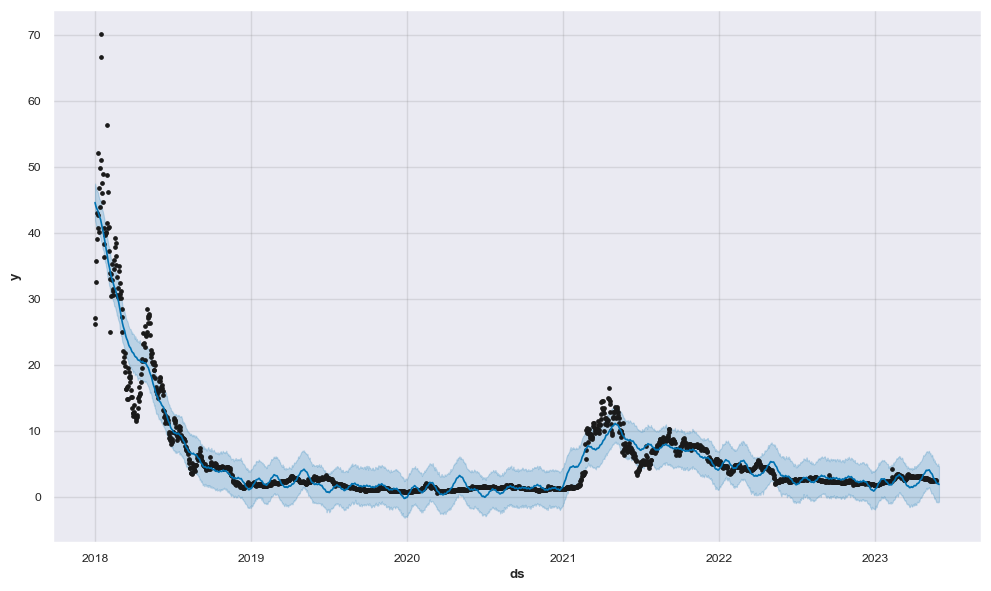

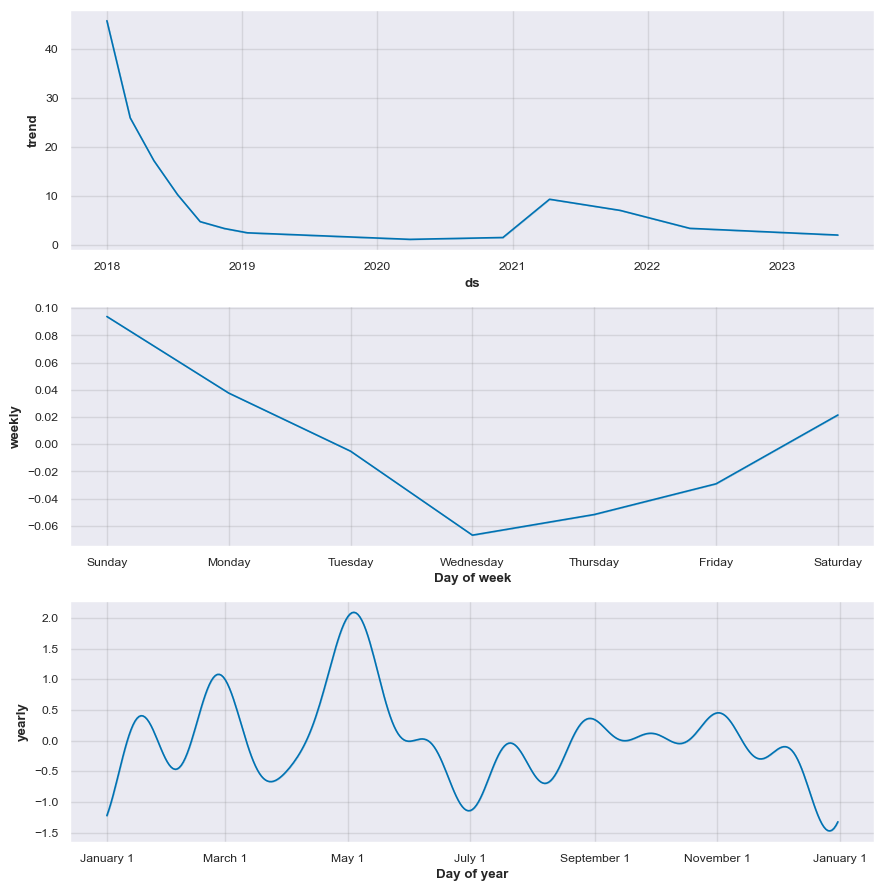

In [523]:
from prophet.plot import plot_plotly, plot_components_plotly

# visulización de las predicciones
fig1 = model.plot(forecast)

# Visualización de los componentes del modelo
fig2 = model.plot_components(forecast)


fig1.show()
fig2.show()

Gráfico de las predicciones:
Este gráfico muestra los datos históricos junto con las predicciones realizadas por el modelo. La línea azul representa los datos observados en el conjunto de entrenamiento, mientras que la línea negra muestra las predicciones realizadas por el modelo. El área sombreada en azul claro representa el intervalo de confianza al 95% de las predicciones.

Gráfico de los componentes del modelo:
Este gráfico descompone la serie temporal en sus componentes principales: tendencia, estacionalidad y efectos de días festivos. El gráfico muestra tres subgráficos:
El primer subgráfico muestra la tendencia, que es una estimación de la dirección general en la que se mueve la serie temporal a largo plazo.
El segundo subgráfico muestra la estacionalidad, que representa los patrones recurrentes o estacionales en los datos.
El tercer subgráfico muestra los efectos de los días festivos, que capturan las desviaciones específicas relacionadas con días festivos u otras ocasiones especiales.

In [524]:
test_gasn

Date     Close  year  month  day
1969 2023-05-24  2.659774  2023      5   24
1970 2023-05-25  2.610458  2023      5   25
1971 2023-05-26  2.545363  2023      5   26
1972 2023-05-27  2.505847  2023      5   27
1973 2023-05-28  2.587448  2023      5   28
1974 2023-05-29  2.688613  2023      5   29
1975 2023-05-30  2.700953  2023      5   30

In [525]:
#  valores reales del conjunto de prueba
test_values = test_gasn['Close'].values

#  predicciones de Prophet
predicted_values = forecast['yhat'].values[-len(test_values):]

df_comparisongn = pd.DataFrame({'Predicciones': predicted_values, 'Valores Reales': test_values})


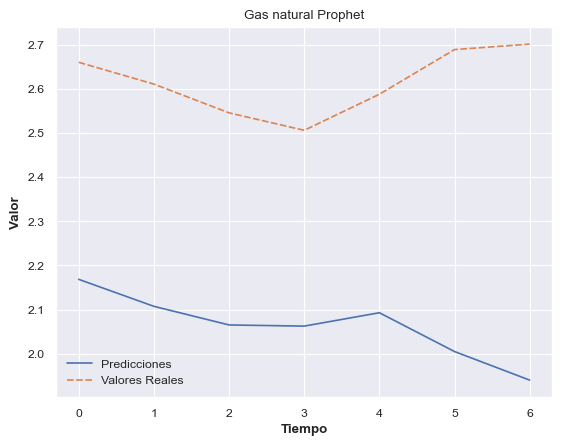

In [526]:
# gráfico  con las predicciones y los valores reales
sns.lineplot(data=df_comparisongn)

plt.title('Gas natural Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Valor')
plt.show()

Evaluar el modelo

In [527]:
# Calcular el MAE
mae = mean_absolute_error(test_values, predicted_values)

# Calcular el MSE
mse = mean_squared_error(test_values, predicted_values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 0.5509543624691491
MSE: 0.3160047618201488
RMSE: 0.5621430083352


MAE (Mean Absolute Error): Es el error absoluto promedio entre las predicciones y los valores reales. Representa la diferencia promedio entre las predicciones y los valores reales, sin tener en cuenta la dirección de la diferencia. Cuanto menor sea el valor del MAE, mejor será el ajuste del modelo.

MSE (Mean Squared Error): Es el error cuadrático promedio entre las predicciones y los valores reales. Calcula la diferencia cuadrática promedio entre las predicciones y los valores reales, lo que da más peso a las diferencias más grandes. Cuanto menor sea el valor del MSE, mejor será el ajuste del modelo.

RMSE (Root Mean Squared Error): Es la raíz cuadrada del MSE y representa el error promedio entre las predicciones y los valores reales en la misma escala que los datos originales. El RMSE se utiliza comúnmente para interpretar el error de predicción en la misma unidad que los datos originales. Cuanto menor sea el valor del RMSE, mejor será el ajuste del modelo.

En resumen, estos resultados indican que el modelo de Prophet tiene un error promedio absoluto (MAE) de 0.5509, un error cuadrático promedio (MSE) de 0.3160 y un error cuadrático promedio raíz (RMSE) de 0.5621. Cuanto más cercanos a cero sean estos valores, mejor será el rendimiento del modelo en la predicción de los valores reales.

### Conclusiones Gas Natural

Esta subida de precios del gas natural en 2022 se debe a la invasión de Ucrania por parte de Rusia que ha afectado al mercado eneerg´rtico

Dado que las energías reonvables no pueden atender toda la demanda, necesitamos combstibles fósiles para producir electricidad

No solo esto si no que otra circunstancia que afecta a su precio es que ha caído la oferta
Causas del aumento de la demanda mundial de gas natural:
- demanda post-pandemia ha ido creciendo
- Europa utiliza gas natural para calentar las viviendas
- Cierre de plantas nucleares y de carbón

# Precio del Uranio

In [528]:
uranio = pd.read_csv('data_materias/uranio.csv')
uranio = uranio.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])

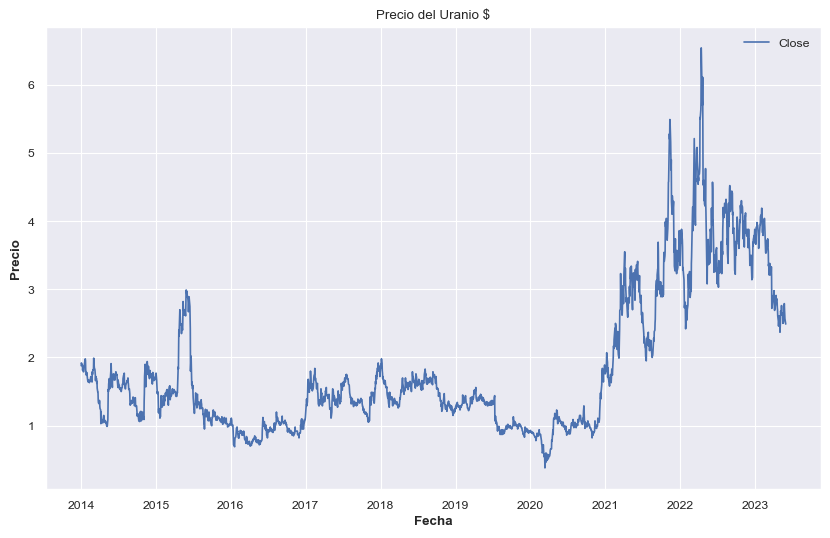

In [529]:
uranio['Date'] = pd.to_datetime(uranio['Date'])

# Establecer el estilo y el contexto de Seaborn
sns.set(style='darkgrid', context='paper')

# Crear una figura con un tamaño personalizado
plt.figure(figsize=(10, 6))

sns.lineplot(x=uranio.Date,y=uranio['Close'], data=uranio['Close'])

plt.title('Precio del Uranio $')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(['Close'])

plt.show()

Filtro a partir de 2018

In [530]:
# Filtrar los datos desde 2018 en adelante
uranio = uranio[uranio['Date'] >= '2018-01-01']

In [531]:
uranio

Date  Close
1007 2018-01-02   1.90
1008 2018-01-03   1.85
1009 2018-01-04   1.94
1010 2018-01-05   1.98
1011 2018-01-08   1.91
...         ...    ...
2363 2023-05-23   2.79
2364 2023-05-24   2.69
2365 2023-05-25   2.64
2366 2023-05-26   2.57
2367 2023-05-30   2.49

[1361 rows x 2 columns]

In [532]:
uranio = uranio.set_index('Date')
date_range = pd.date_range(start=uranio.index.min(), end=uranio.index.max())
filled_uranio = pd.merge(pd.DataFrame(date_range, columns=['Date']), uranio, how='left', left_on='Date', right_index=True)

filled_uranio = filled_uranio.fillna(method='ffill')


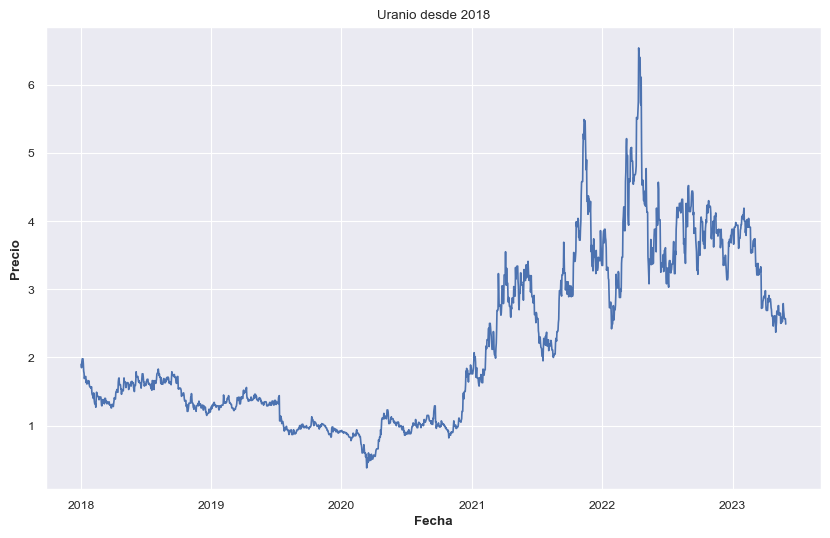

In [533]:
# Visualizar los datos filtrados
sns.set(style='darkgrid', context='paper')
plt.figure(figsize=(10, 6))
sns.lineplot(x=filled_uranio['Date'], y=filled_uranio['Close'])
plt.title('Uranio desde 2018')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.show()

Utilizo el mismo modelo que he empleado para las predicciones del gas natural con Prophet

In [534]:
#poner el limite de división

# Establecer la fecha límite para la división
fecha = pd.to_datetime('2023-05-24')

# Obtener el índice máximo que cumpla la condición de fecha límite
index = filled_uranio[filled_uranio['Date'] <= fecha]['Date'].idxmax()

# Dividir en conjuntos de entrenamiento y prueba
train_uranio = filled_uranio[:index]
test_uranio = filled_uranio[index:]



In [535]:
test_uranio

Date  Close
1968 2023-05-24   2.69
1969 2023-05-25   2.64
1970 2023-05-26   2.57
1971 2023-05-27   2.57
1972 2023-05-28   2.57
1973 2023-05-29   2.57
1974 2023-05-30   2.49

In [536]:

## Prophet
train_data = train_uranio[['Date', 'Close']].copy()
train_data.columns = ['ds', 'y']

train_data.head()
# creo instancia de prophet y entreno el modelo

model = Prophet()
model.fit(train_data)

# que me haga predicciones sobre mi test
future = model.make_future_dataframe(periods=len(test_uranio), freq='D')   # test uranio está vacío, no está haciendo predicciones futuras

#dataframe de predicciones
forecast = model.predict(future)


09:25:44 - cmdstanpy - INFO - Chain [1] start processing
09:25:44 - cmdstanpy - INFO - Chain [1] done processing


Gráficando resultados

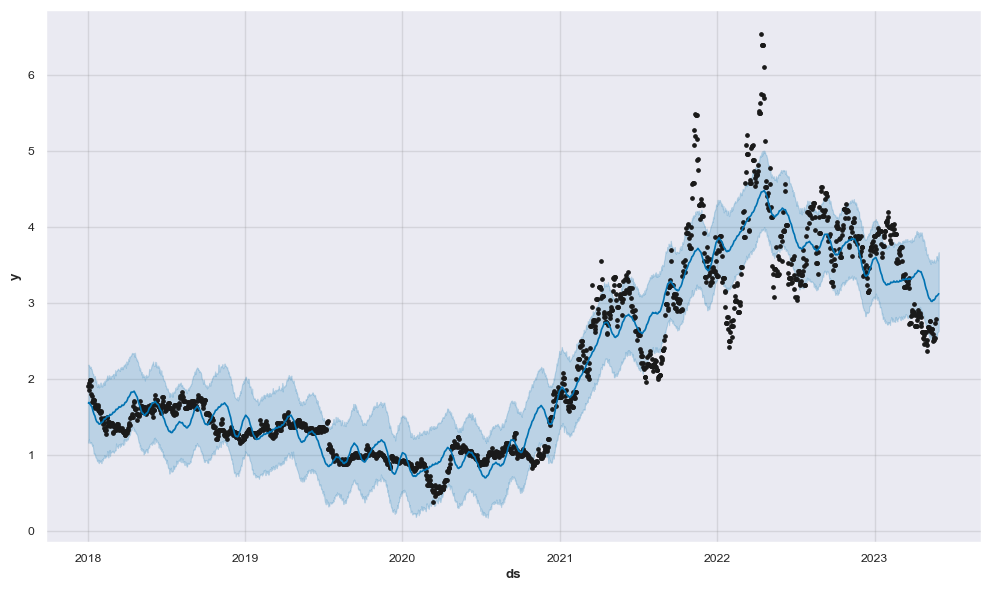

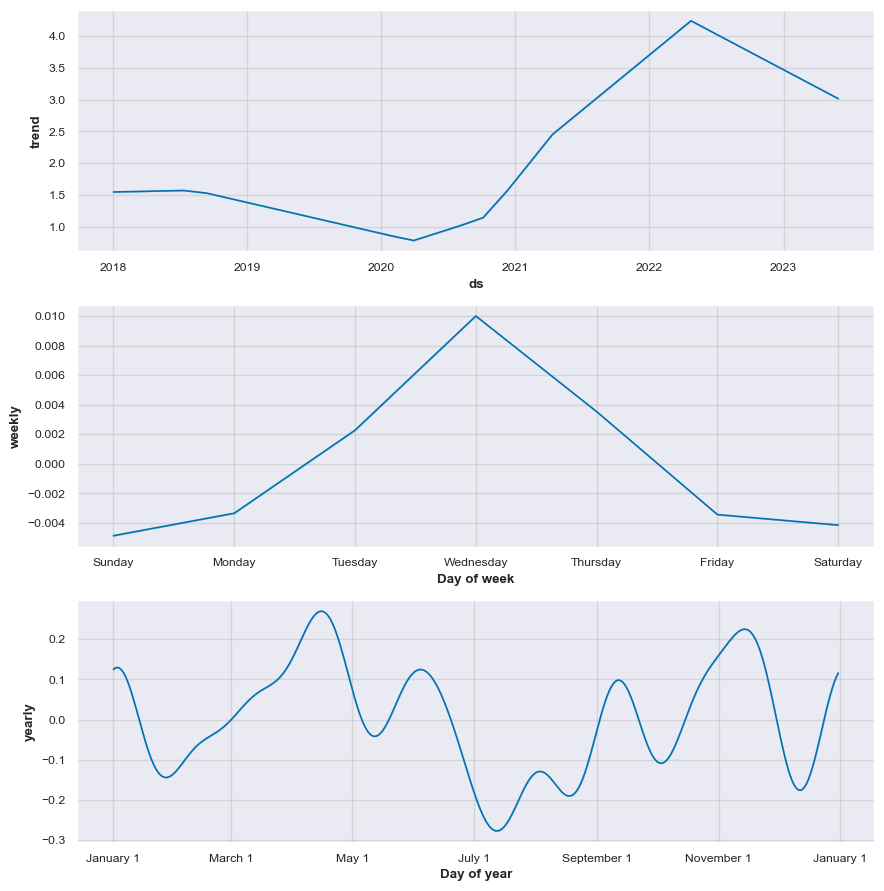

In [537]:
# visulización de las predicciones
fig1 = model.plot(forecast)

# Visualización de los componentes del modelo
fig2 = model.plot_components(forecast)


fig1.show()
fig2.show()


In [538]:
# valores reales del conjunto de prueba
test_values = train_uranio['Close'].values

# predicciones de Prophet
predicted_values = forecast['yhat'].values[-len(test_values):]

In [539]:
# Crear un DataFrame con las dos columnas
df_comparison = pd.DataFrame({'Predicciones': predicted_values, 'Valores Reales': test_values})

df_comparison.tail()

Predicciones  Valores Reales
1963      3.089777            2.53
1964      3.096257            2.53
1965      3.102005            2.53
1966      3.109116            2.73
1967      3.119329            2.79

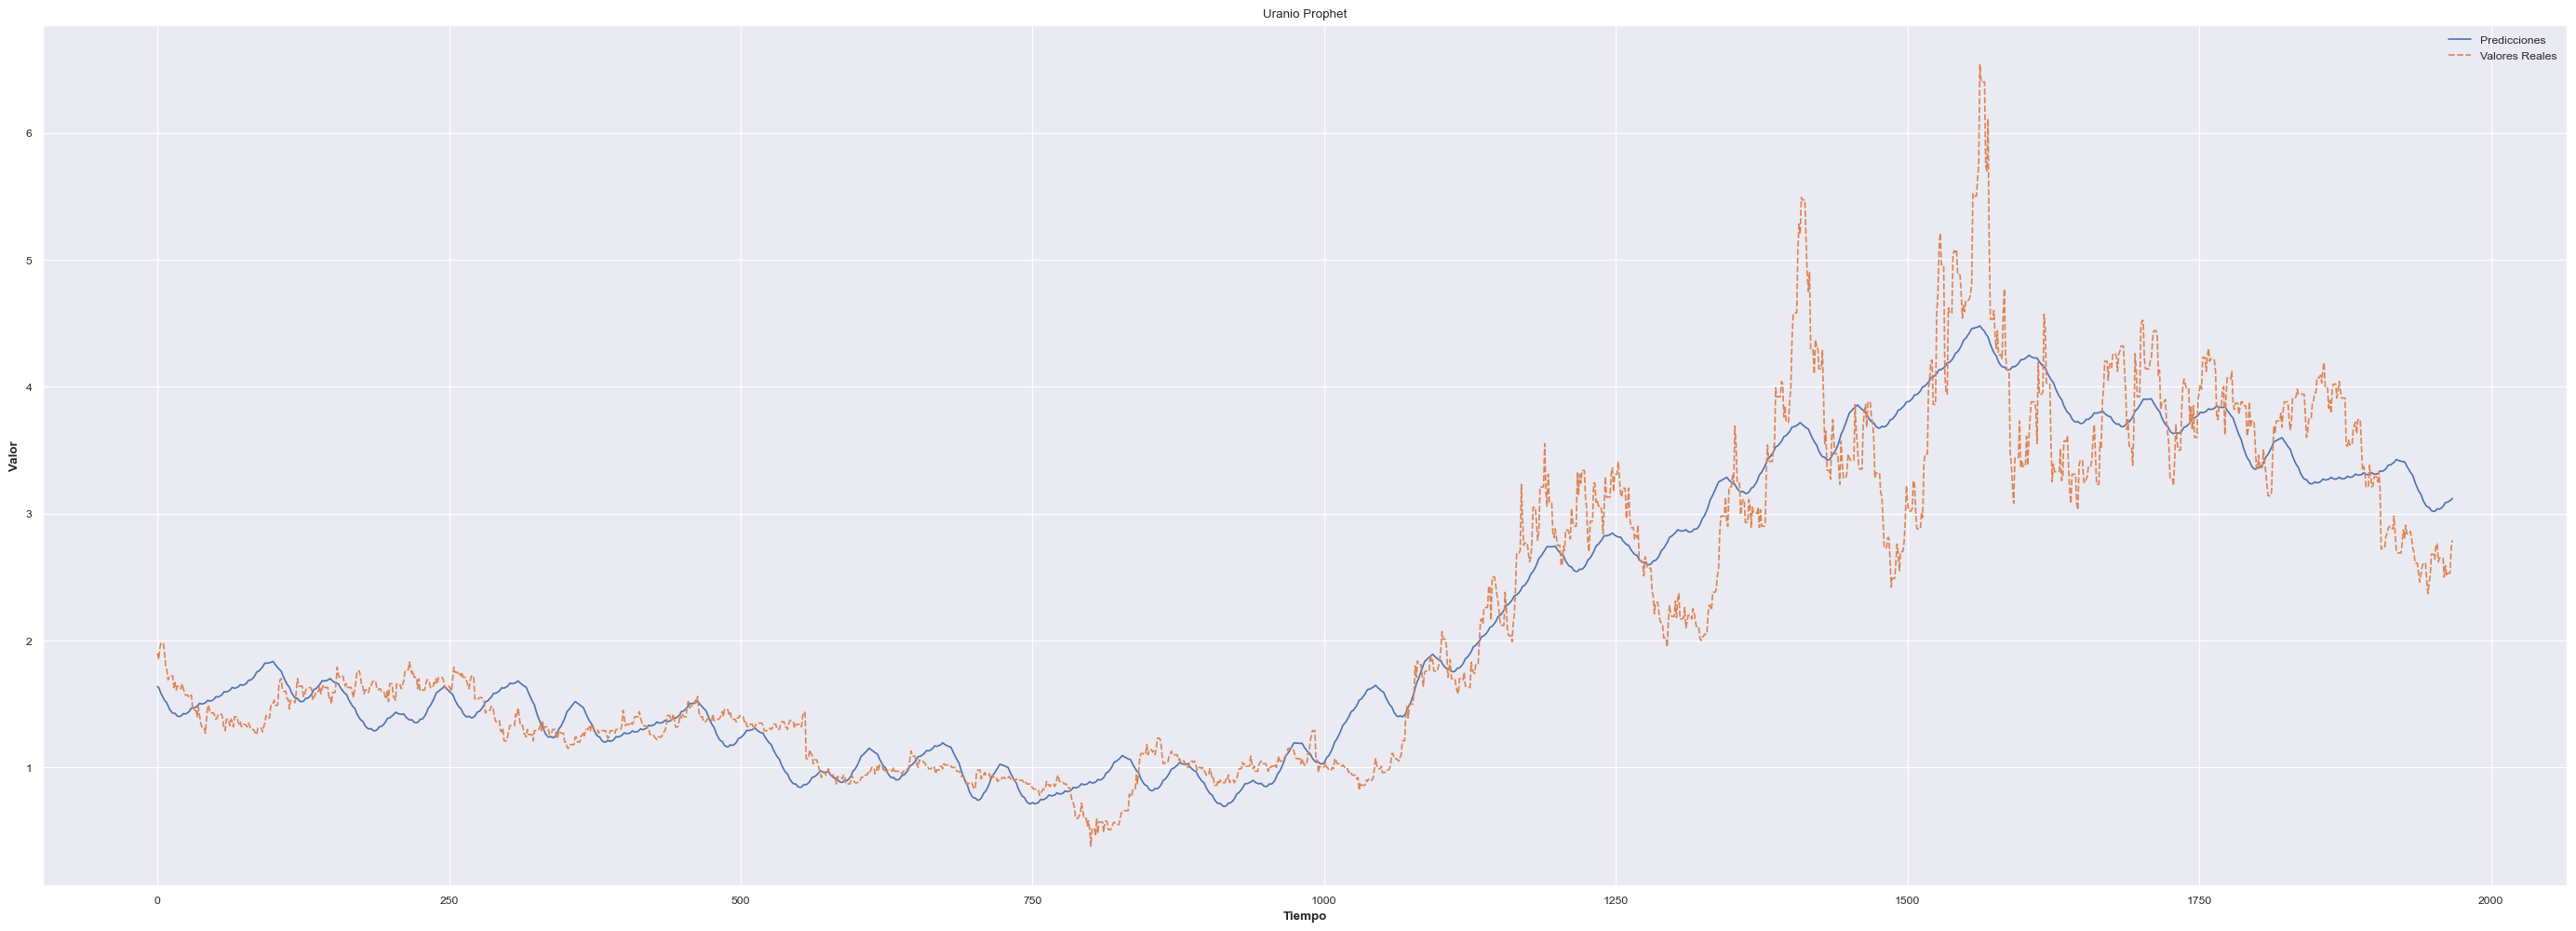

In [540]:
# gráfico l con las predicciones y los valores reales


fig = plt.figure(figsize=(35,12))

sns.lineplot(data=df_comparison)

plt.title('Uranio Prophet')
plt.xlabel('Tiempo')
plt.ylabel('Valor')

plt.show()

Evaluar el modelo

In [541]:

# Calcular el MAE
mae = mean_absolute_error(test_values, predicted_values)

# Calcular el MSE
mse = mean_squared_error(test_values, predicted_values)

# Calcular el RMSE
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)


MAE: 0.28529821240702397
MSE: 0.15712753227843093
RMSE: 0.39639315367250094


In [542]:
train_data

ds     y
0    2018-01-02  1.90
1    2018-01-03  1.85
2    2018-01-04  1.94
3    2018-01-05  1.98
4    2018-01-06  1.98
...         ...   ...
1963 2023-05-19  2.53
1964 2023-05-20  2.53
1965 2023-05-21  2.53
1966 2023-05-22  2.73
1967 2023-05-23  2.79

[1968 rows x 2 columns]

### Predicciones para los próximos 7 días

In [543]:
# Obtener la última fecha en el conjunto de entrenamiento
ultima_fecha_entrenamiento = train_data['ds'].max()

# Crear el rango de fechas para los próximos 10 días
fechas_proximos_10_dias = pd.date_range(start=ultima_fecha_entrenamiento + pd.DateOffset(10), end='2023-06-09')

# Crear el dataframe con las fechas para las predicciones
uranio_pred = pd.DataFrame({'ds': fechas_proximos_10_dias})

# Obtener las predicciones para los próximos 10 días
uranio_pred['yhat'] = model.predict(uranio_pred)['yhat']

uranio_pred


ds      yhat
0 2023-06-02  3.120509
1 2023-06-03  3.119598
2 2023-06-04  3.117385
3 2023-06-05  3.116109
4 2023-06-06  3.117643
5 2023-06-07  3.120028
6 2023-06-08  3.106986
7 2023-06-09  3.092263

In [544]:
uranio_pred.rename(columns={"ds": "fecha", "yhat": "Precio"}, inplace=True)


## Precio del Uranio con XGB

In [545]:
filled_uranio['year'] = filled_uranio['Date'].dt.year
filled_uranio['month'] = filled_uranio['Date'].dt.month
filled_uranio['day'] = filled_uranio['Date'].dt.day

In [546]:
x = filled_uranio.iloc[:, -3:].values  #input
y = filled_uranio.iloc[:, 1].values #output price only

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=5,shuffle=False)

XGBOOST

XGBRegressor (XGBR): XGBR es una implementación del algoritmo de refuerzo llamado Extreme Gradient Boosting (XGBoost). Es similar a GBR, pero utiliza una técnica de refuerzo mejorada y optimizaciones adicionales para lograr un rendimiento más rápido y preciso. XGBoost ha demostrado ser eficaz en una amplia gama de problemas de aprendizaje automático y es ampliamente utilizado en competencias de Kaggle.


In [547]:
xgbr=XGBR()
xgbr.fit(x_train, y_train)
y_pred=xgbr.predict(x_test)

mean_squared_error(y_test, y_pred, squared=False)  # RMSE


0.408220156681049

In [548]:
y_pred

array([2.8392246, 2.9587967, 2.9845524, 3.0019627, 2.991127 ],
      dtype=float32)

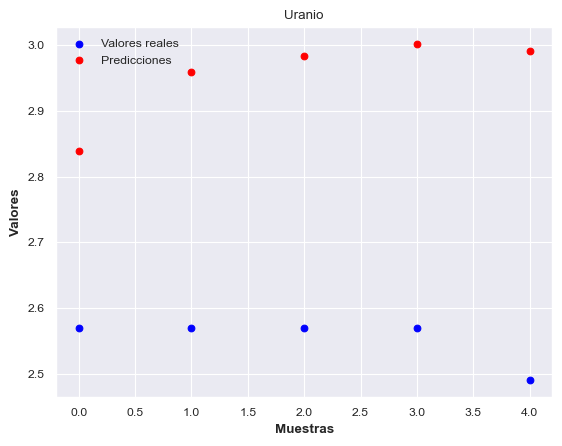

In [549]:

# gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores reales')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Uranio')
plt.legend()
plt.show()


Para el uranio XGB Regressor no funciona tan bien

## Generación de renovables

In [550]:
renovables = pd.read_csv('clean_data/renovables.csv')

# Paso 1: Eliminar la columna "Hidroeólica" y el Indice
renovables = renovables.drop('Unnamed: 0', axis=1)
renovables = renovables.drop('Hidroeólica', axis=1)

# Paso 2: Crear la nueva columna "Solar" como la suma de "Solar fotovoltaica" y "Solar térmica"
renovables['Solar'] = renovables['Solar fotovoltaica'] + renovables['Solar térmica']

# Paso 3: Eliminar las columnas "Solar fotovoltaica" y "Solar térmica"
renovables = renovables.drop(['Solar fotovoltaica', 'Solar térmica'], axis=1)

# Convertir la columna "Fecha" a datetime
renovables['Fecha'] = pd.to_datetime(renovables['Fecha'], format='%d/%m/%Y')


In [551]:
renovables.head()

Fecha  Hidráulica      Eólica  Otras renovables  Residuos renovables  \
0 2020-01-01  151.481978   23.525794          8.373805             2.454439   
1 2020-01-02  159.171675   77.426389          8.407882             2.115271   
2 2020-01-03  151.996921   84.099112          8.992384             2.115966   
3 2020-01-04  139.873002  125.320489          9.549843             2.221634   
4 2020-01-05  126.801179   61.809342         10.030028             2.247091   

       Solar  
0  27.960236  
1  22.901504  
2  18.079815  
3  24.877053  
4  32.125610

In [552]:
renovables['year'] = renovables['Fecha'].dt.year
renovables['month'] = renovables['Fecha'].dt.month
renovables['day'] = renovables['Fecha'].dt.day

### Predicciones con XGB REGRESSOR

RMSE para la columna "Hidráulica": 19.5748204455532


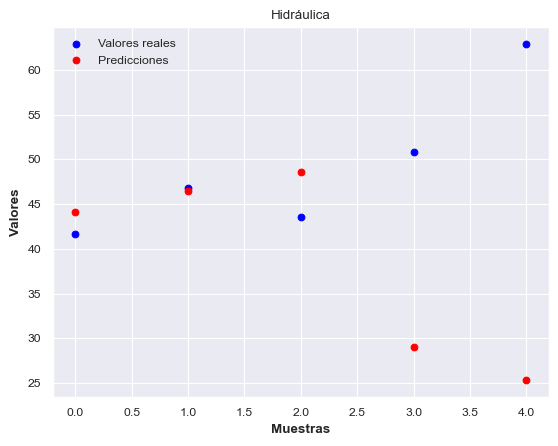

RMSE para la columna "Eólica": 122.31533501167414


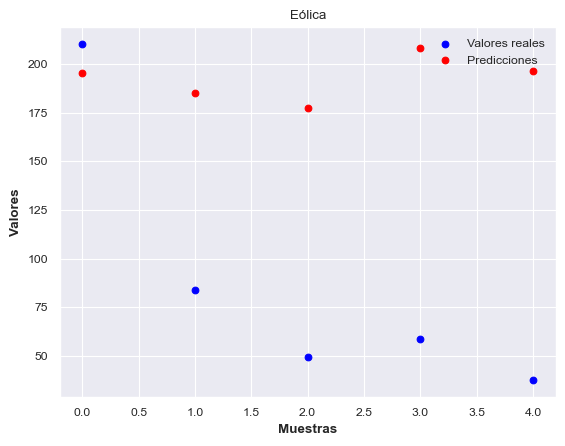

RMSE para la columna "Solar": 40.23307902008423


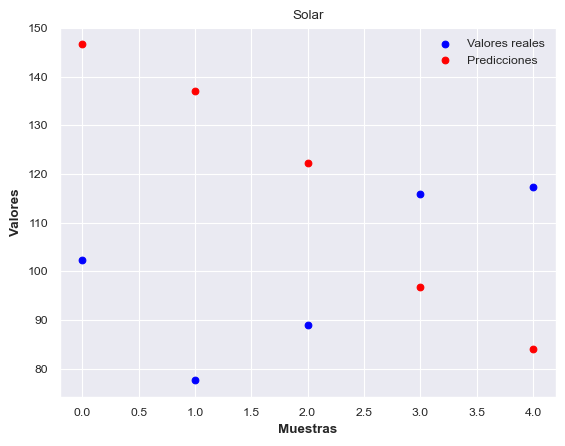

RMSE para la columna "Otras renovables": 0.6359608202312316


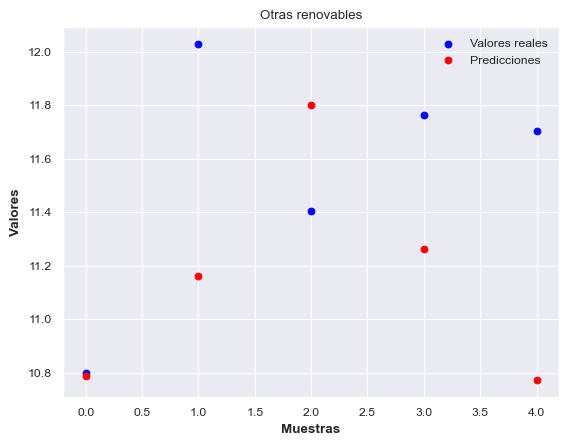

RMSE para la columna "Residuos renovables": 0.4624408882264266


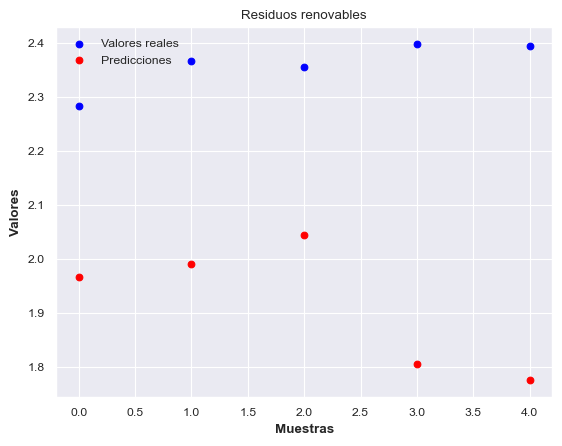

In [553]:
# Diccionario para almacenar las predicciones
predicciones = {}

# Obtener las columnas de potencia generada
columnas_potencia = ['Hidráulica', 'Eólica', 'Solar', 'Otras renovables', 'Residuos renovables']

for columna in columnas_potencia:
    # Definir los datos de entrada (x) y salida (y) para la columna actual
    x = renovables[['year', 'month', 'day']].values
    y = renovables[columna].values
    
    # Dividir los datos en conjunto de entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=5, shuffle=False)
    
    # Crear el modelo XGBRegressor
    xgbr = XGBR()
    
    # Entrenar el modelo
    xgbr.fit(x_train, y_train)
    
    # Realizar predicciones en el conjunto de prueba
    y_pred = xgbr.predict(x_test)
    
    # Calcular el error RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'RMSE para la columna "{columna}": {rmse}')
    
    # Almacenar las predicciones en el diccionario
    predicciones[columna] = y_pred

    # Graficar los valores reales y las predicciones
    plt.scatter(range(len(y_test)), y_test, color='blue', label='Valores reales')
    plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
    plt.xlabel('Muestras')
    plt.ylabel('Valores')
    plt.title(columna)
    plt.legend()
    plt.show()

# Convertir el diccionario en un DataFrame
df_predicciones = pd.DataFrame(predicciones)


In [554]:
df_predicciones

Hidráulica      Eólica       Solar  Otras renovables  Residuos renovables
0   44.072075  195.408463  146.725082         10.787475             1.967151
1   46.496578  185.201920  137.039978         11.159973             1.991455
2   48.540817  177.715302  122.276199         11.799983             2.044088
3   28.988010  208.551620   96.845352         11.262226             1.806213
4   25.340763  196.679733   83.984886         10.772620             1.775996

In [555]:
renovables.tail(5)

Fecha  Hidráulica      Eólica  Otras renovables  \
1241 2023-05-26     41.6624  210.392500          10.79782   
1242 2023-05-27     46.7669   83.687496          12.02782   
1243 2023-05-28     43.5155   49.557405          11.40592   
1244 2023-05-29     50.8219   58.580648          11.76121   
1245 2023-05-30     62.8643   37.432230          11.70251   

      Residuos renovables       Solar  year  month  day  
1241             2.282750  102.242471  2023      5   26  
1242             2.365950   77.627623  2023      5   27  
1243             2.354900   88.999581  2023      5   28  
1244             2.397725  115.868949  2023      5   29  
1245             2.394800  117.387611  2023      5   30

Hidraulica bien, el resto mal


### Probando con Prophet

09:25:51 - cmdstanpy - INFO - Chain [1] start processing
09:25:52 - cmdstanpy - INFO - Chain [1] done processing


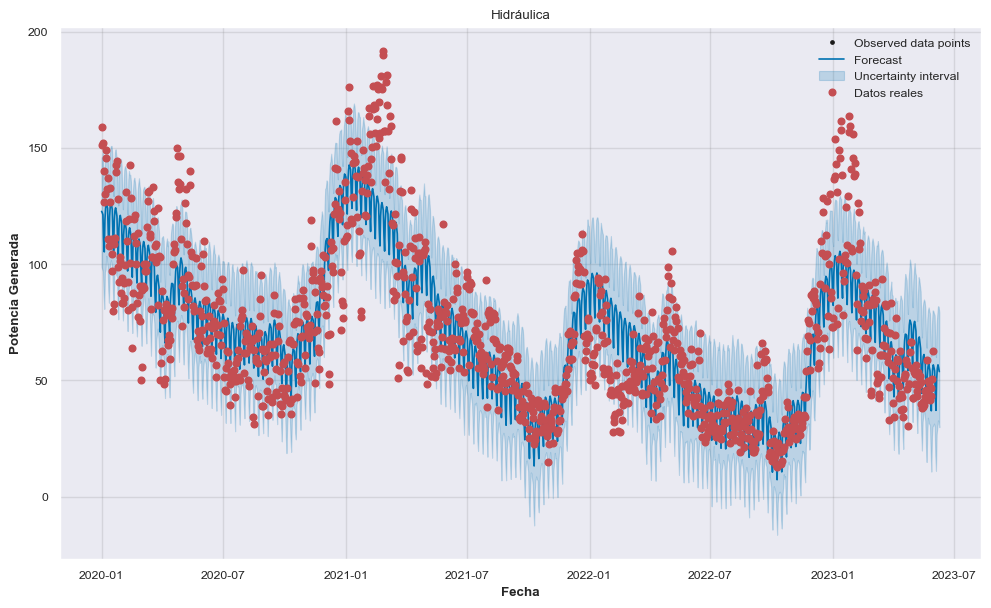

09:25:52 - cmdstanpy - INFO - Chain [1] start processing
09:25:53 - cmdstanpy - INFO - Chain [1] done processing


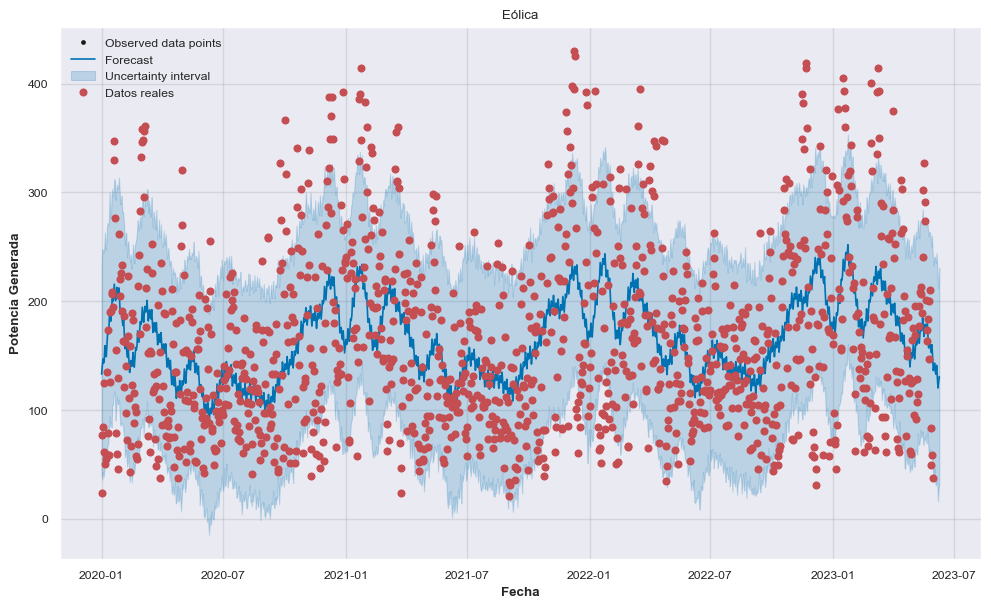

09:25:53 - cmdstanpy - INFO - Chain [1] start processing
09:25:53 - cmdstanpy - INFO - Chain [1] done processing


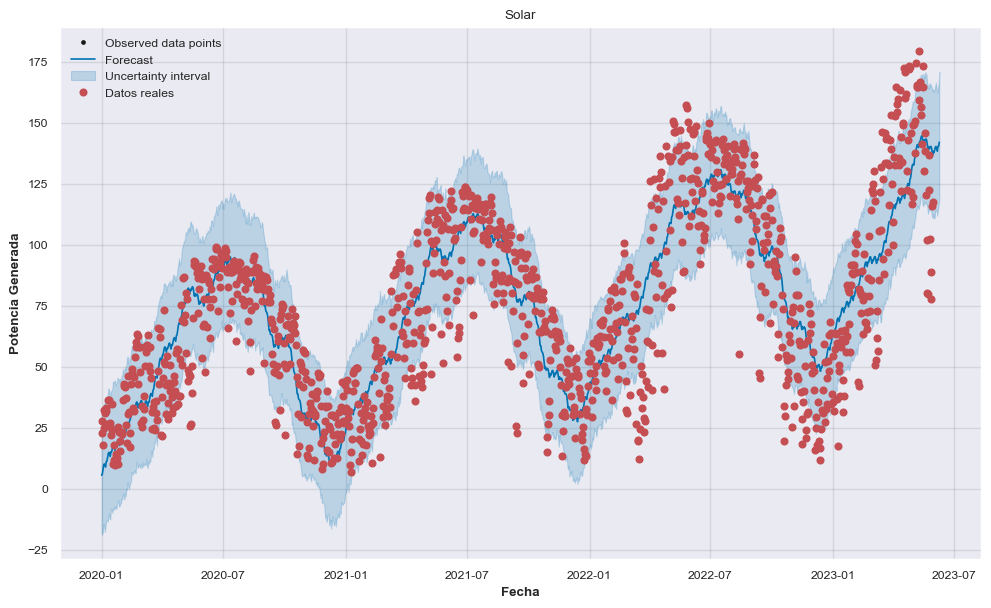

09:25:54 - cmdstanpy - INFO - Chain [1] start processing
09:25:54 - cmdstanpy - INFO - Chain [1] done processing


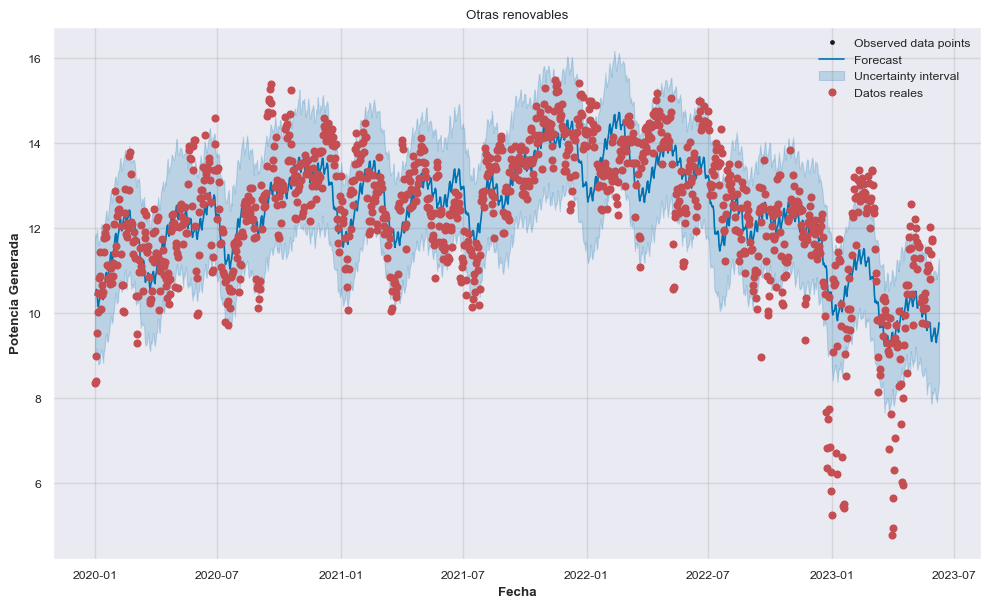

09:25:55 - cmdstanpy - INFO - Chain [1] start processing
09:25:55 - cmdstanpy - INFO - Chain [1] done processing


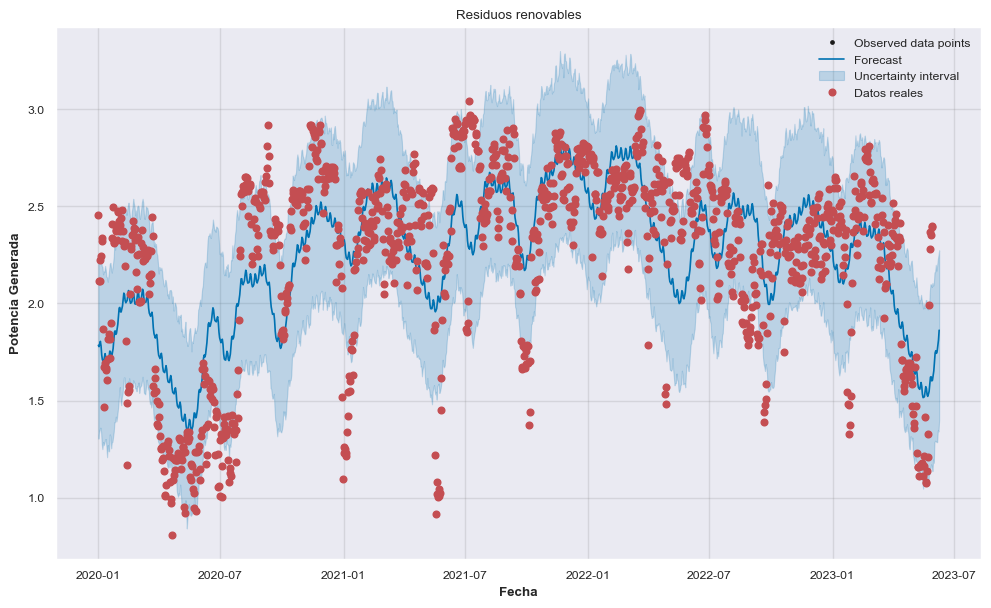

In [556]:
renovables_pred = pd.DataFrame(columns=['Fecha'] + columnas_potencia)

for columna in columnas_potencia:
    # Obtén los datos correspondientes a la columna actual
    datos = renovables[['Fecha', columna]].rename(columns={'Fecha': 'ds', columna: 'y'})

    # Crea un nuevo modelo Prophet
    modelo = Prophet()

    # Ajusta el modelo a los datos
    modelo.fit(datos)

    # Genera un DataFrame con las fechas futuras para realizar predicciones
    futuras_fechas = modelo.make_future_dataframe(periods=10)

    # Realiza las predicciones
    predicciones = modelo.predict(futuras_fechas)

    # Guarda los valores de predicción en el DataFrame
    renovables_pred[columna] = predicciones['yhat'].tail(10)

    # Grafica los resultados
    modelo.plot(predicciones, xlabel='Fecha', ylabel='Potencia Generada', figsize=(10, 6))
    plt.title(columna)
    
    # Obtén los datos reales correspondientes a los últimos 5 días
    datos_reales_columna = renovables[['Fecha', columna]].rename(columns={'Fecha': 'ds', columna: 'y'})
    
    # Grafica los datos reales
    plt.plot(datos_reales_columna['ds'], datos_reales_columna['y'], 'ro', label='Datos reales')
    plt.legend()
    plt.show()

# Agrega las fechas al DataFrame
renovables_pred['Fecha'] = futuras_fechas['ds'].tail(10)


In [557]:
renovables_pred

Fecha  Hidráulica      Eólica       Solar  Otras renovables  \
1246 2023-05-31   56.701184  136.356825  138.255689          9.466501   
1247 2023-06-01   55.574051  140.505167  137.780534          9.530188   
1248 2023-06-02   54.135444  143.102506  138.817232          9.653081   
1249 2023-06-03   43.418605  134.873517  139.958295          9.649309   
1250 2023-06-04   37.121195  132.958959  140.242069          9.400750   
1251 2023-06-05   50.469984  141.122396  139.216105          9.315062   
1252 2023-06-06   55.099757  130.055159  138.307860          9.465616   
1253 2023-06-07   56.717961  120.270818  140.344034          9.519234   
1254 2023-06-08   55.435506  126.186242  140.449533          9.620559   
1255 2023-06-09   53.806696  130.737557  142.028906          9.779002   

      Residuos renovables  
1246             1.627453  
1247             1.652430  
1248             1.700328  
1249             1.745749  
1250             1.756550  
1251             1.743286  
1252             1.753773  
1253             1.782306  
1254             1.811635  
1255             1.862345

In [558]:
renovables.tail()

Fecha  Hidráulica      Eólica  Otras renovables  \
1241 2023-05-26     41.6624  210.392500          10.79782   
1242 2023-05-27     46.7669   83.687496          12.02782   
1243 2023-05-28     43.5155   49.557405          11.40592   
1244 2023-05-29     50.8219   58.580648          11.76121   
1245 2023-05-30     62.8643   37.432230          11.70251   

      Residuos renovables       Solar  year  month  day  
1241             2.282750  102.242471  2023      5   26  
1242             2.365950   77.627623  2023      5   27  
1243             2.354900   88.999581  2023      5   28  
1244             2.397725  115.868949  2023      5   29  
1245             2.394800  117.387611  2023      5   30

### Exportando csv

In [559]:
renovables = renovables.drop(columns=['year', 'month', 'day'])
#renovables.to_csv('renovables_clean.csv')

In [560]:
filled_gasn = filled_gasn[pd.to_datetime(filled_gasn['Date']).dt.year >= 2020]
filled_gasn = filled_gasn.loc[:, ['Date', 'Close']]
#filled_gasn.to_csv('gasnatural_clean.csv')

In [561]:
filled_uranio = filled_uranio[pd.to_datetime(filled_uranio['Date']).dt.year >= 2020]
filled_uranio = filled_uranio.loc[:, ['Date', 'Close']]
#filled_uranio.to_csv('uranio_clean.csv')

## Predicción Demanda

In [562]:
demanda = pd.read_csv('clean_data/demanda.csv')

In [563]:
demanda['Fecha'] = pd.to_datetime(demanda['Fecha'])
demanda = demanda.drop('Unnamed: 0', axis=1)


Evolución de la demanda

Text(0, 0.5, 'Demanda')

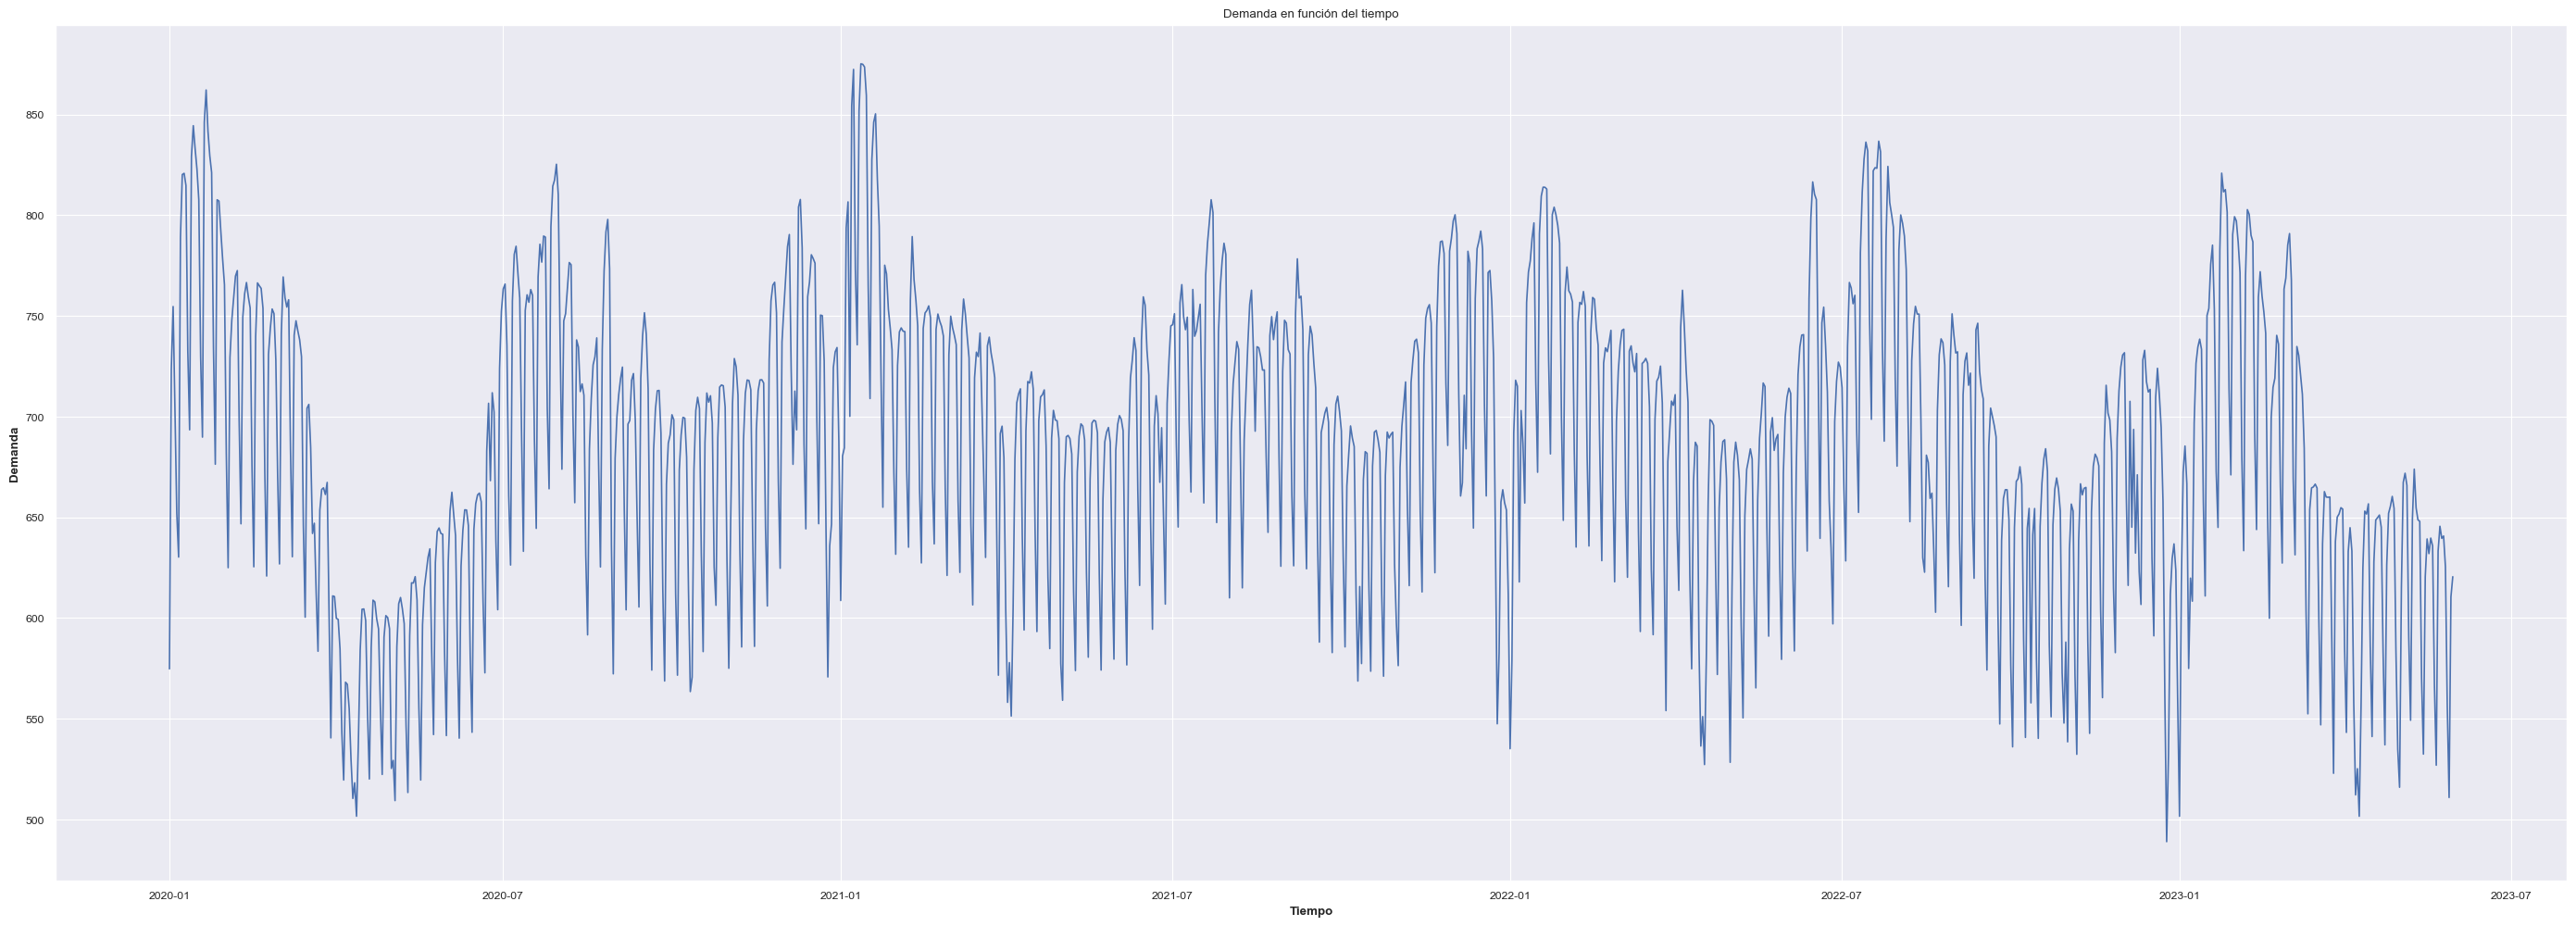

In [564]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(35,12))

sns.lineplot(x=demanda['Fecha'], y=demanda['Demanda'])

plt.title('Demanda en función del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Demanda')


Se observa que la media de la demanda va disminuyendo progresivamente

### Precio por mes para cada año

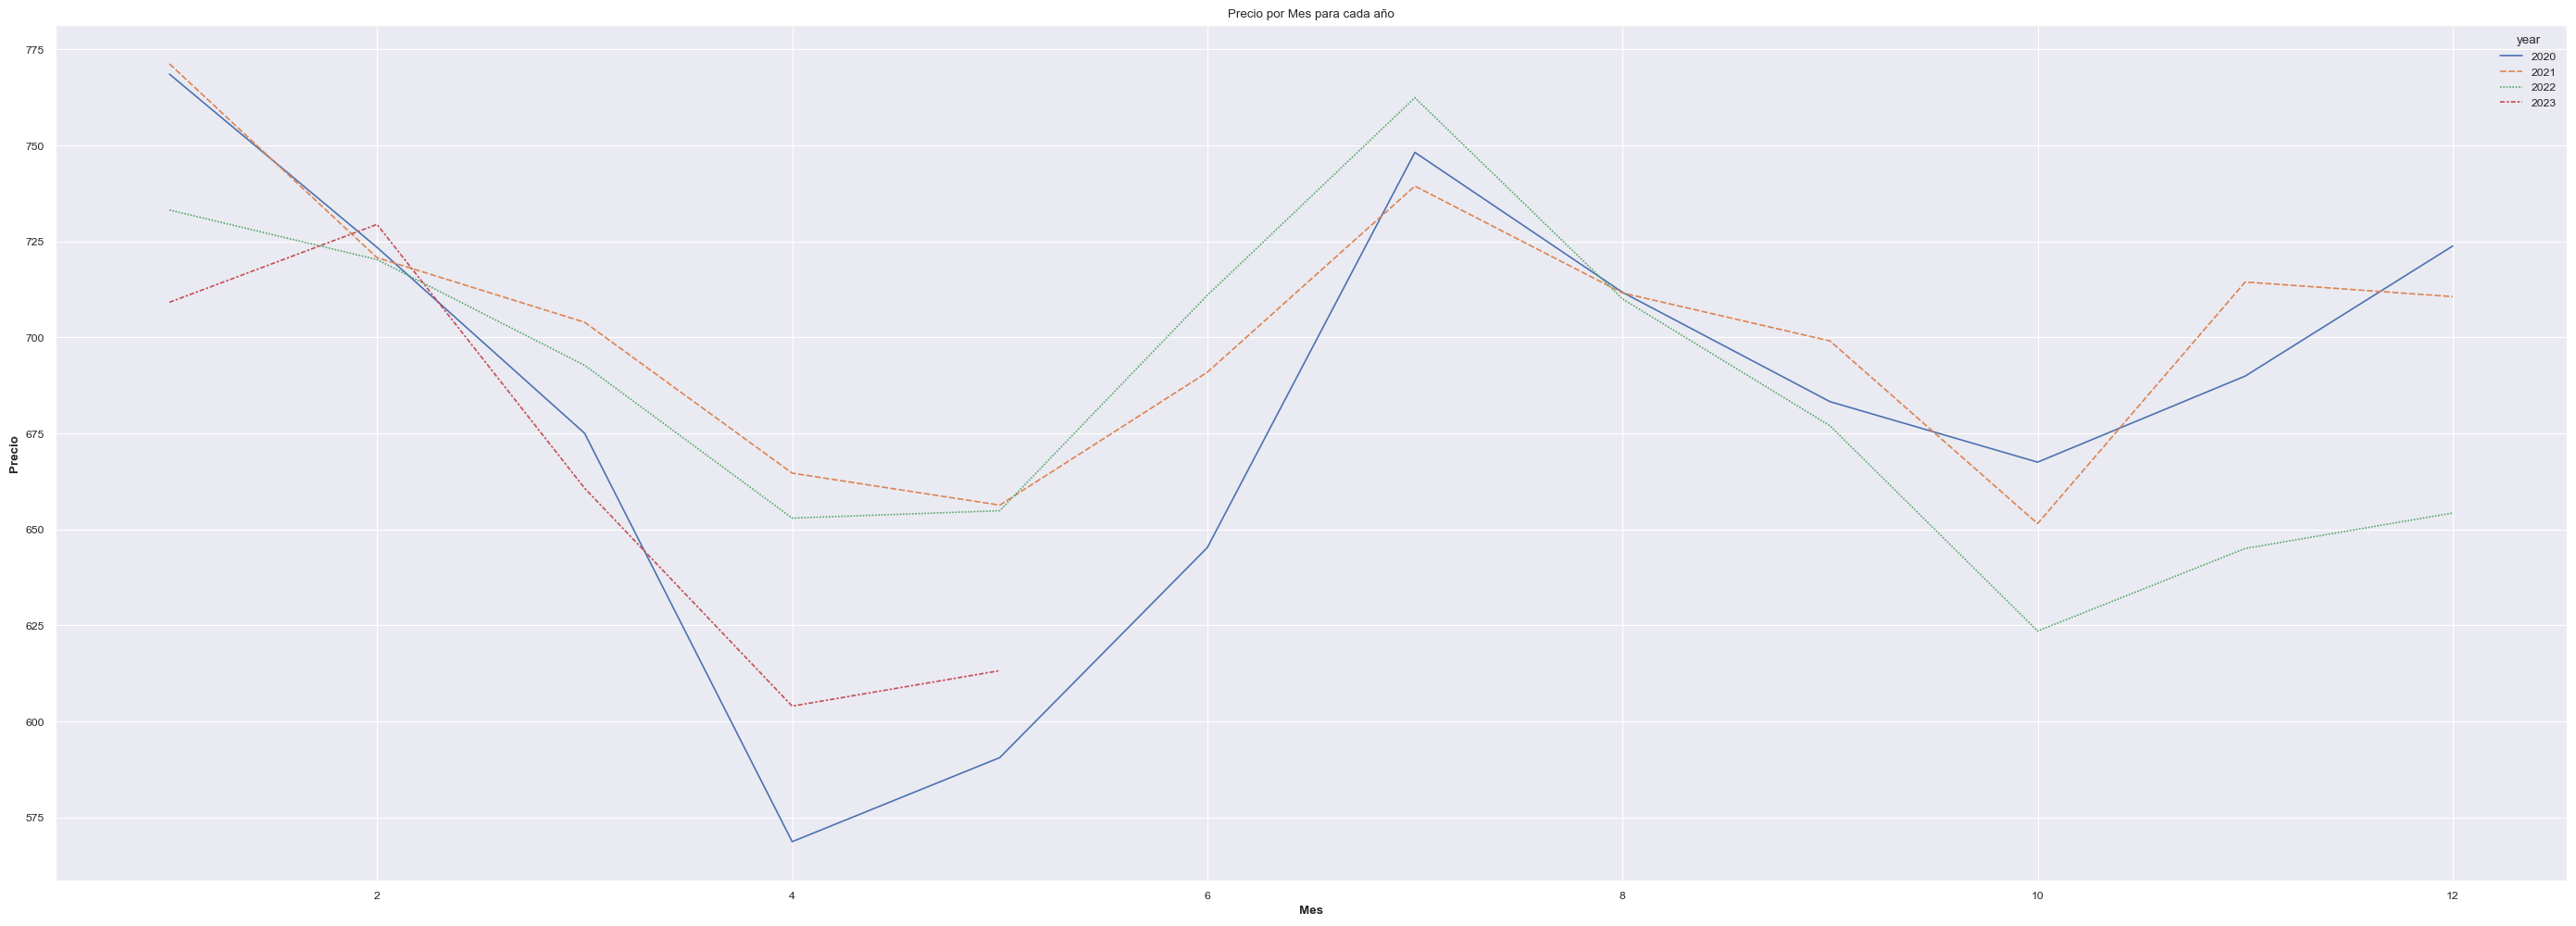

In [565]:
fig = plt.figure(figsize=(35,12))
sns.set_style("darkgrid")

# Obtener el mes y el año de la columna "Fecha"
demanda['mes'] = demanda['Fecha'].dt.month
demanda['year'] = demanda['Fecha'].dt.year

# Crear la tabla pivotante utilizando pd.pivot_table()
df_pivot = pd.pivot_table(demanda, index='mes', columns='year', values='Demanda')

# Crear el gráfico utilizando Seaborn
ax = sns.lineplot(data=df_pivot)

# Configurar el título y las etiquetas de los ejes
plt.title('Precio por Mes para cada año')
plt.xlabel('Mes')
plt.ylabel('Precio')

# Mostrar el gráfico
plt.show()

del gráfico se observa que debido al covid hubo una caida en la demanda 
para eliminar ruido al modelo se cogen los datos a partir del 2020-07-01

In [566]:
# Convertir la columna "Fecha" a tipo datetime si no está en ese formato
demanda['Fecha'] = pd.to_datetime(demanda['Fecha'])

# Filtrar el dataset a partir del mes 7 del año 2020
demanda = demanda.query('Fecha >= "2020-07-01"')

Text(0, 0.5, 'Demanda')

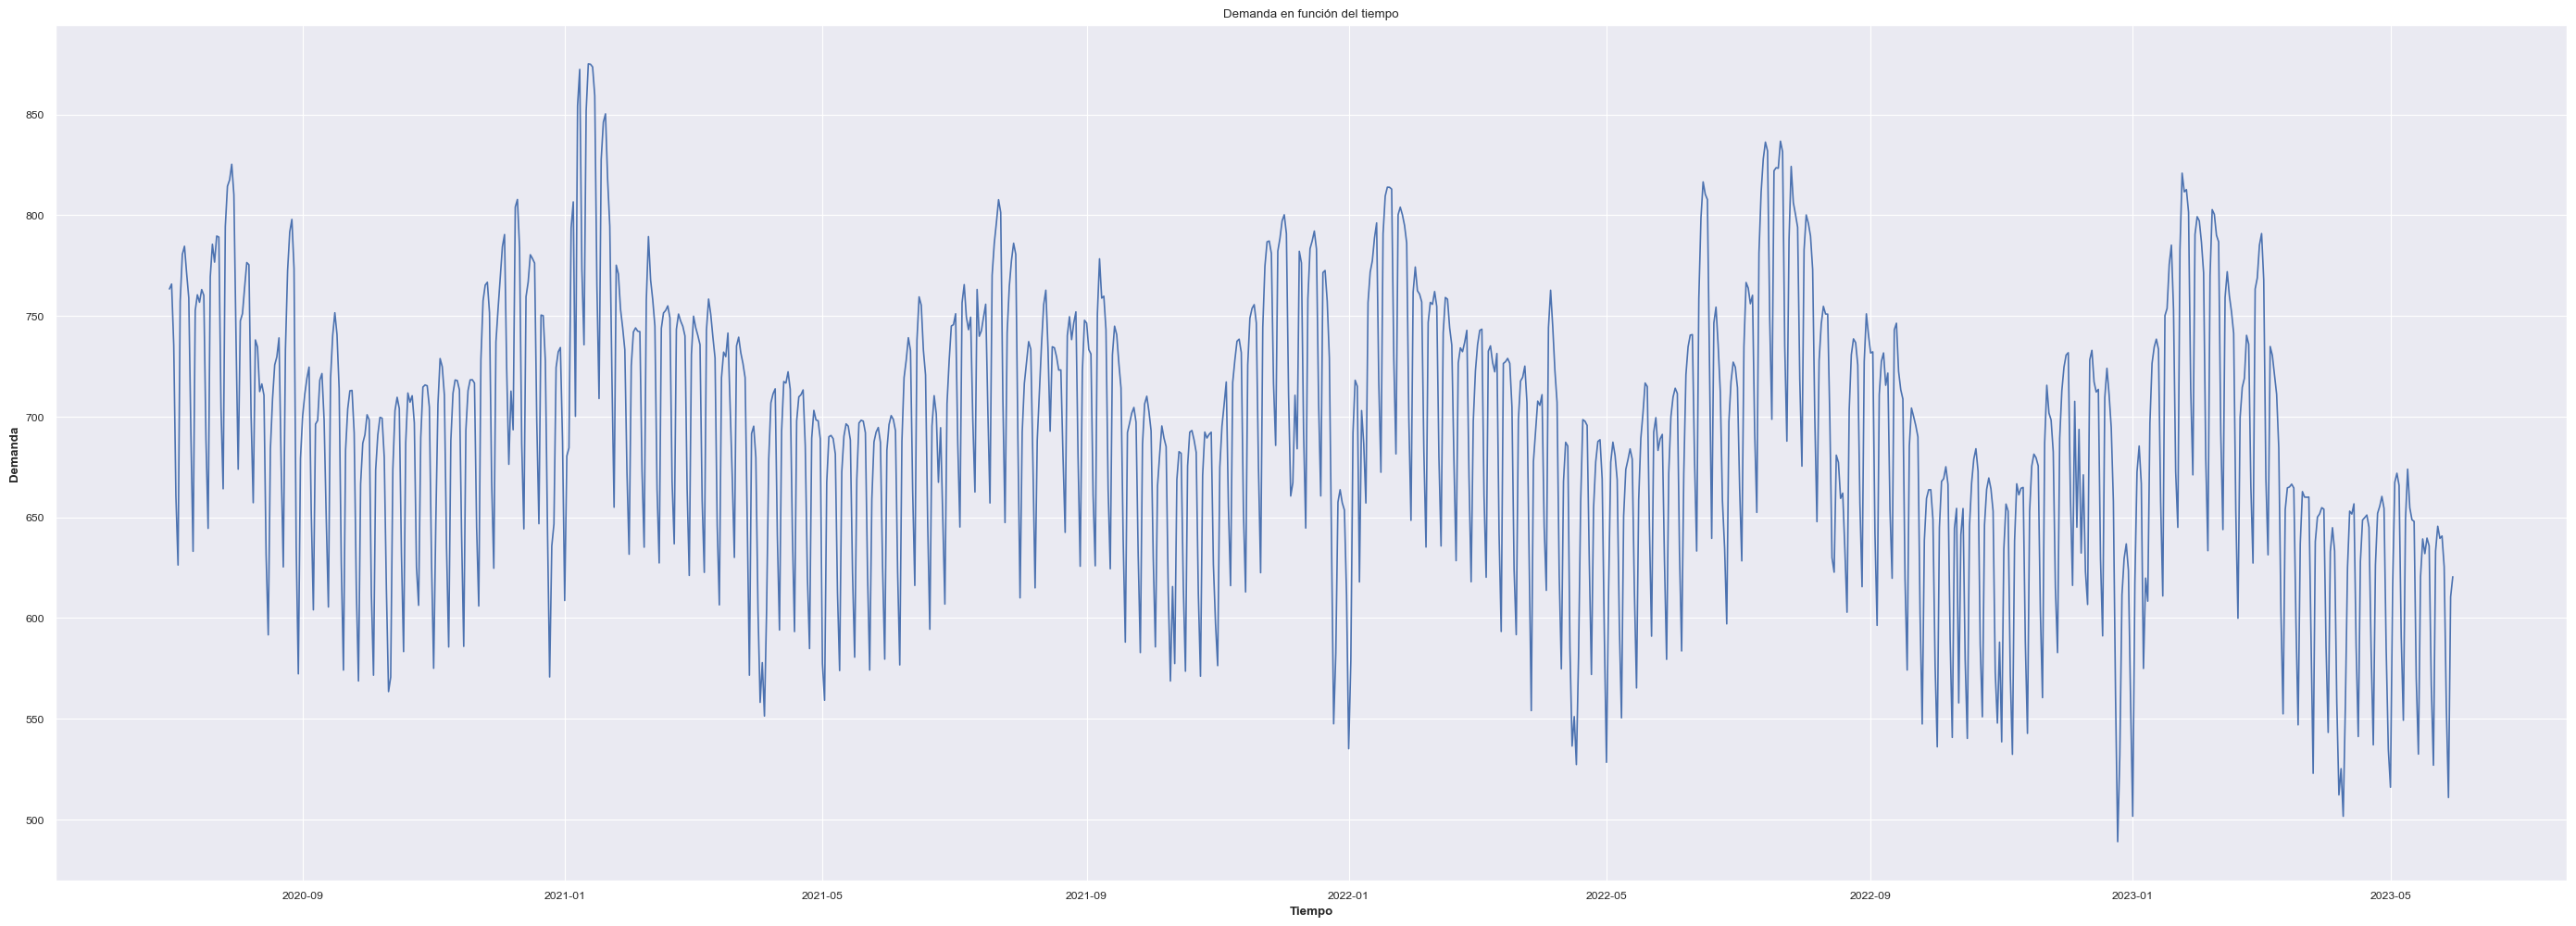

In [567]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(35,12))

sns.lineplot(x=demanda['Fecha'], y=demanda['Demanda'])

plt.title('Demanda en función del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Demanda')


Demanda acumulada al mes

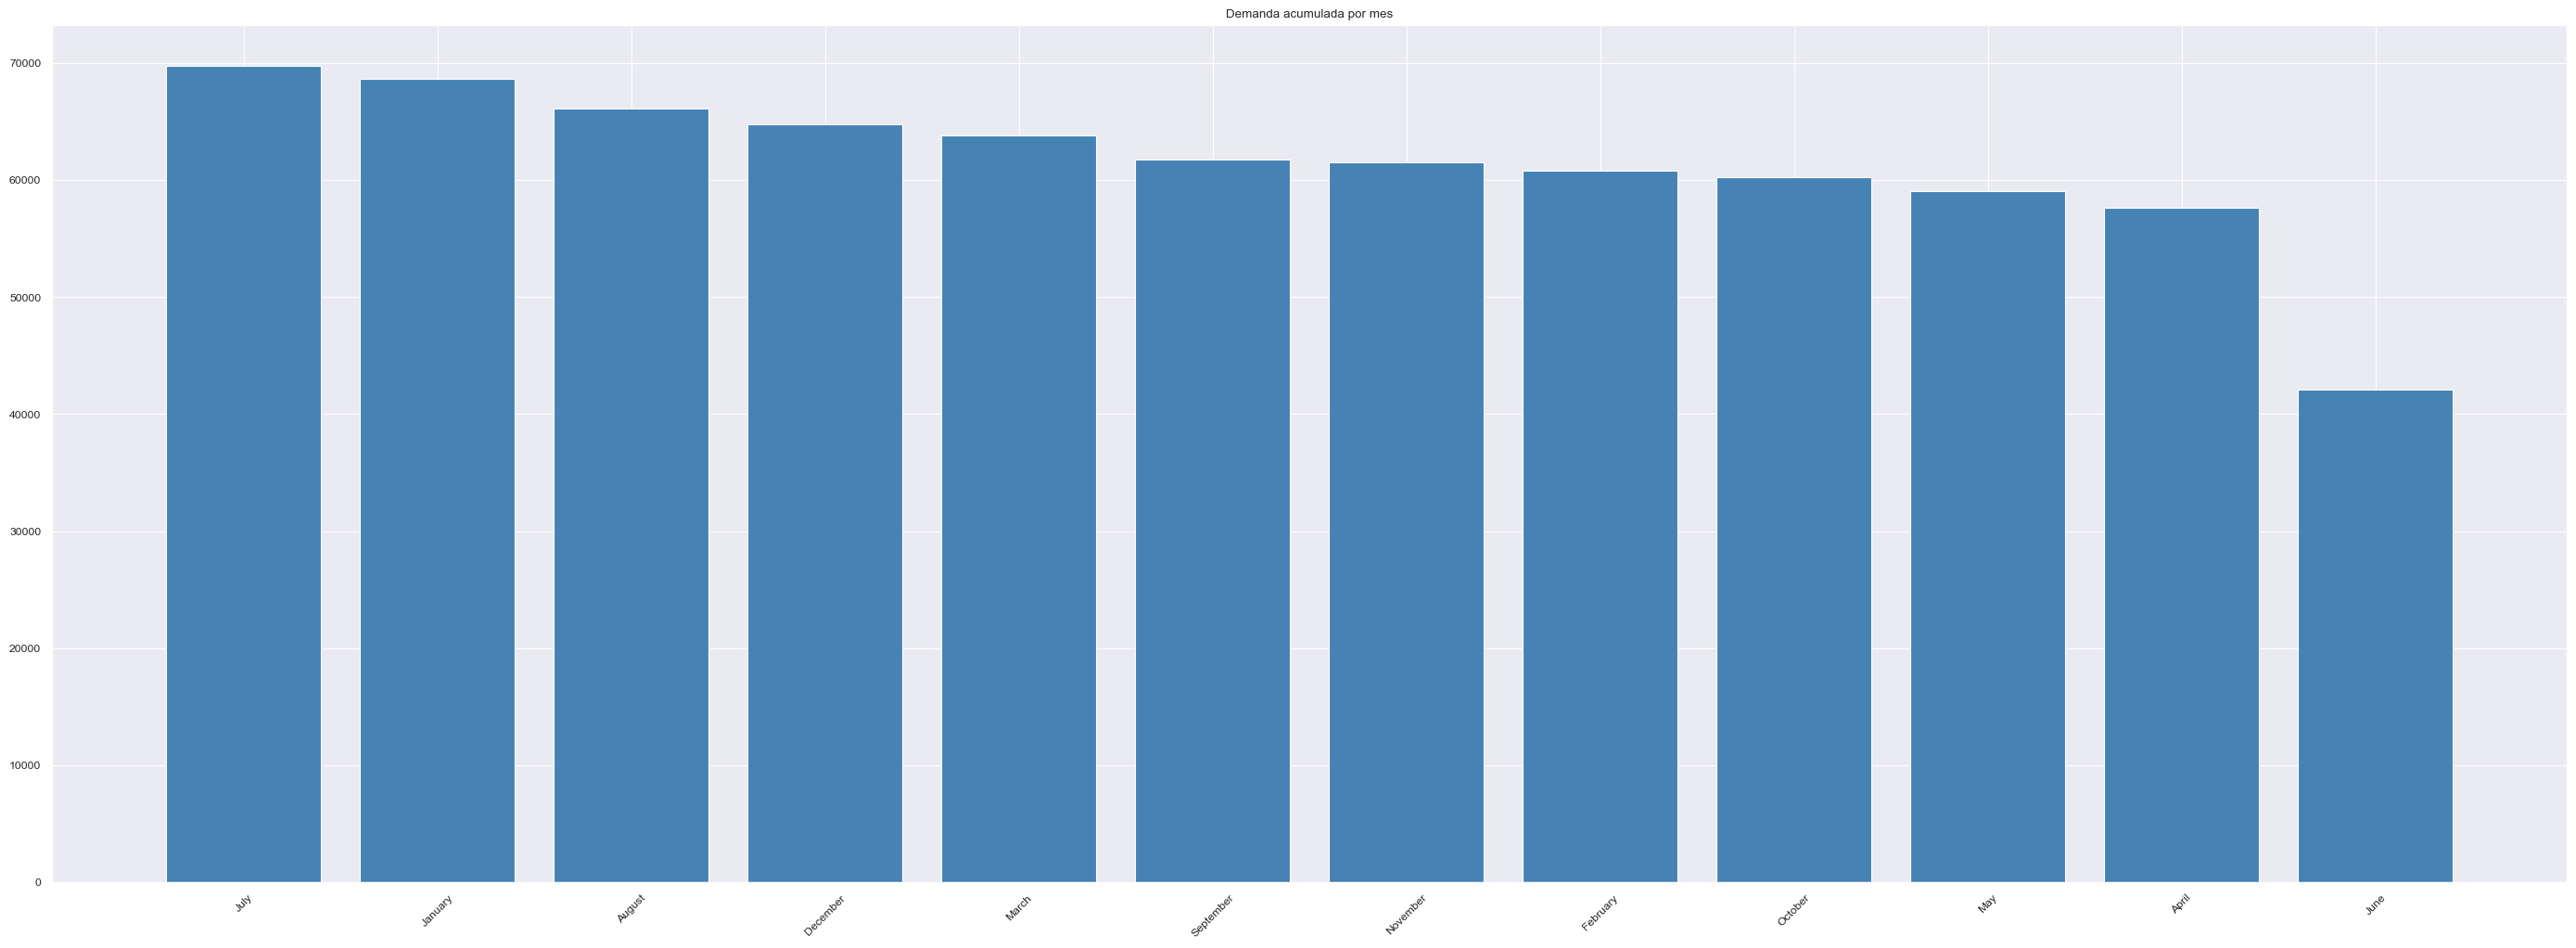

In [568]:
datos_mes = demanda.copy()
datos_mes = datos_mes.reset_index()
datos_mes = pd.DataFrame(datos_mes.groupby(datos_mes['Fecha'].dt.strftime('%B'))['Demanda'].sum())
datos_mes = datos_mes.reset_index()

datos_mes = datos_mes.sort_values(by="Demanda", ascending = False)
sns.set_style("darkgrid")
fig = plt.figure(figsize=(35,12))
plt.bar(datos_mes['Fecha'], datos_mes['Demanda'], color = 'steelblue')
plt.xticks(rotation = 45)
plt.title('Demanda acumulada por mes');

Demanda acumulada semana

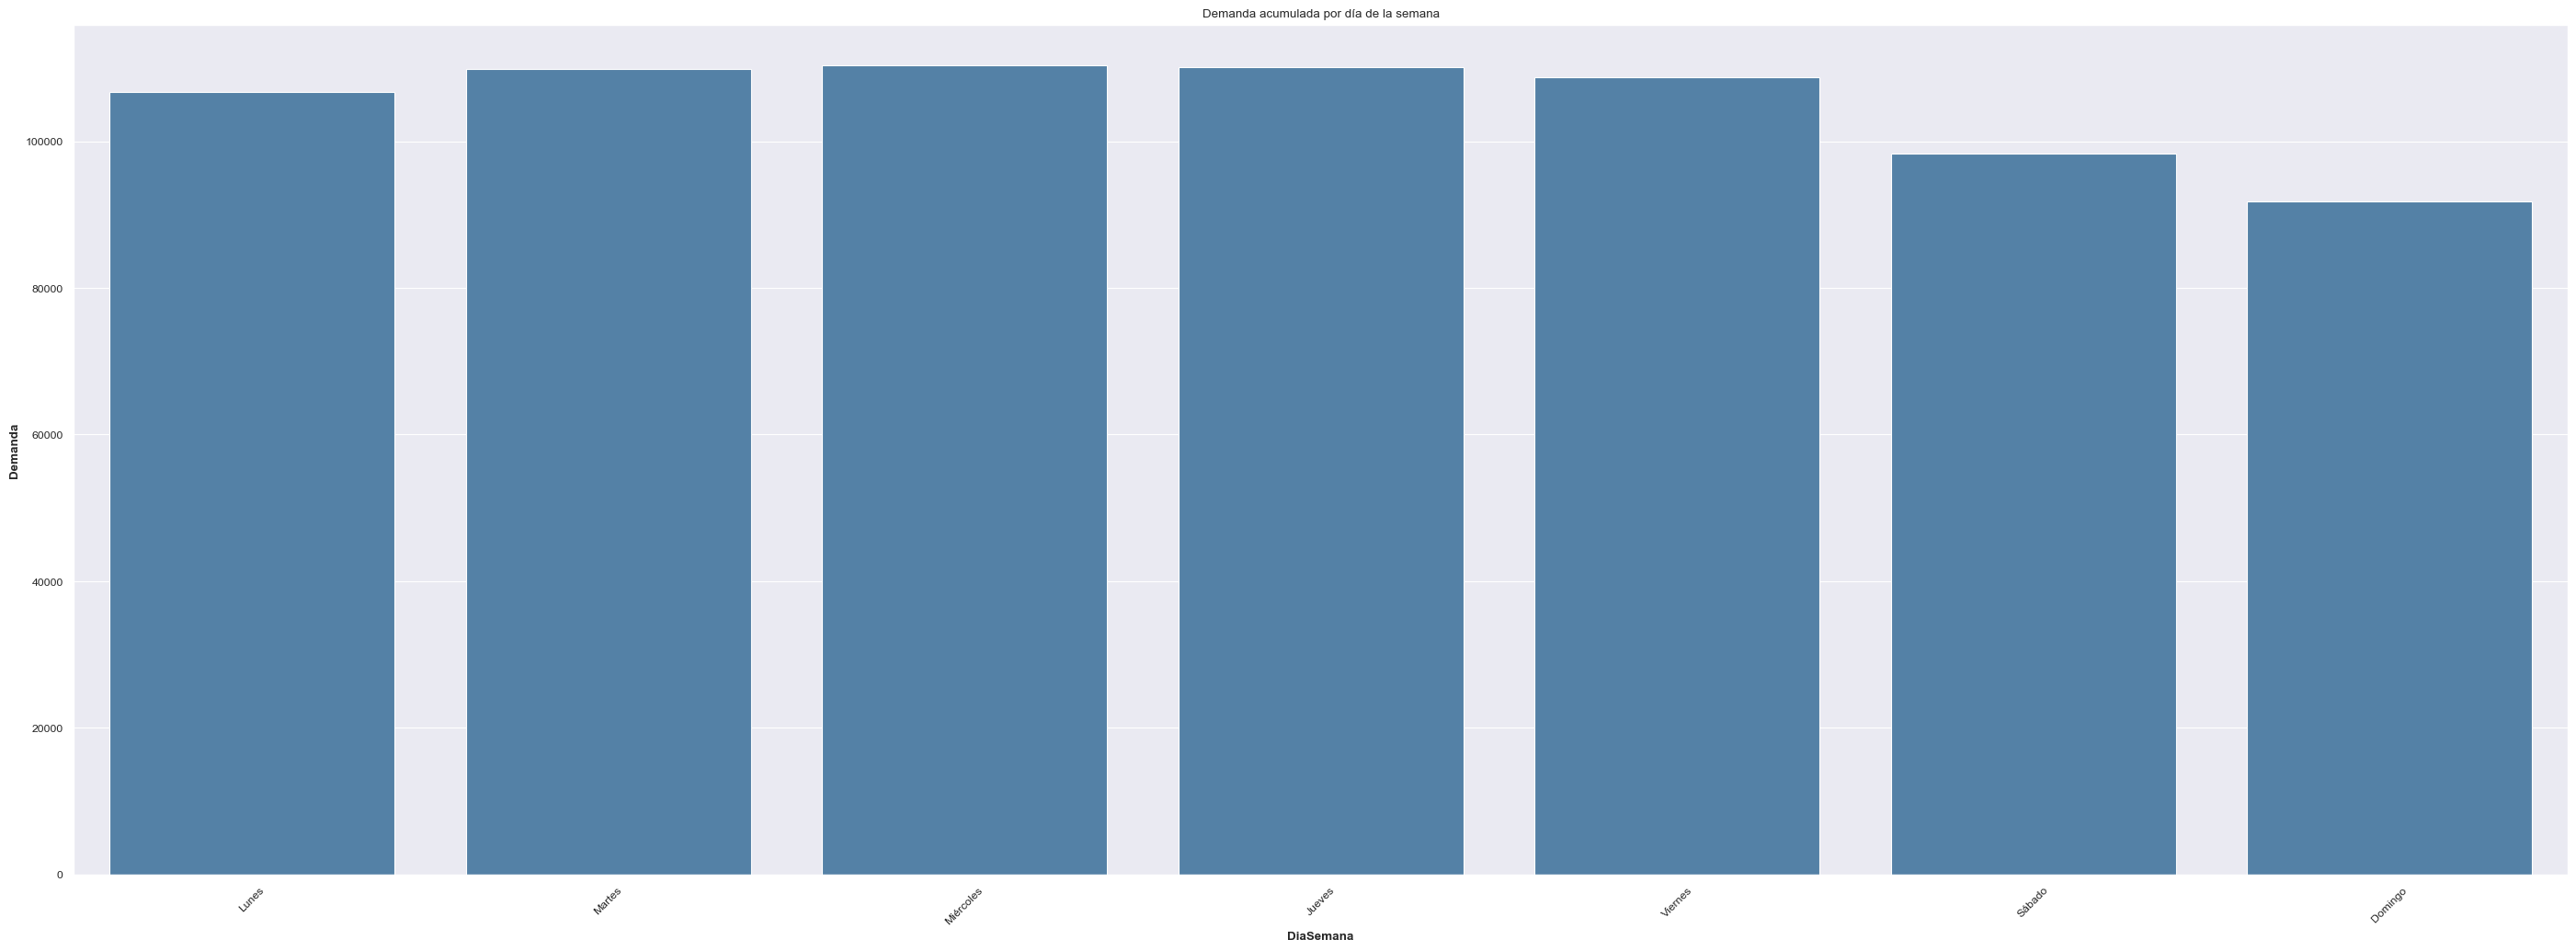

In [569]:
datos_dia_semana = demanda.copy()

# Día de la semana (0: lunes, 1: martes, ..., 6: domingo)
datos_dia_semana['DiaSemana'] = datos_dia_semana['Fecha'].dt.dayofweek

# Demanda acumulada por día de la semana
datos_dia_semana = pd.DataFrame(datos_dia_semana.groupby('DiaSemana')['Demanda'].sum())

# Mapear los valores numéricos de día de la semana a nombres de días
dias_semana = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
datos_dia_semana['DiaSemana'] = datos_dia_semana.index.map(lambda x: dias_semana[x])


sns.set_style("darkgrid")
fig = plt.figure(figsize=(35,12))
sns.barplot(data=datos_dia_semana, x='DiaSemana', y='Demanda', color='steelblue')
plt.xticks(rotation=45)
plt.title('Demanda acumulada por día de la semana')
plt.show()


Observando un solo mes

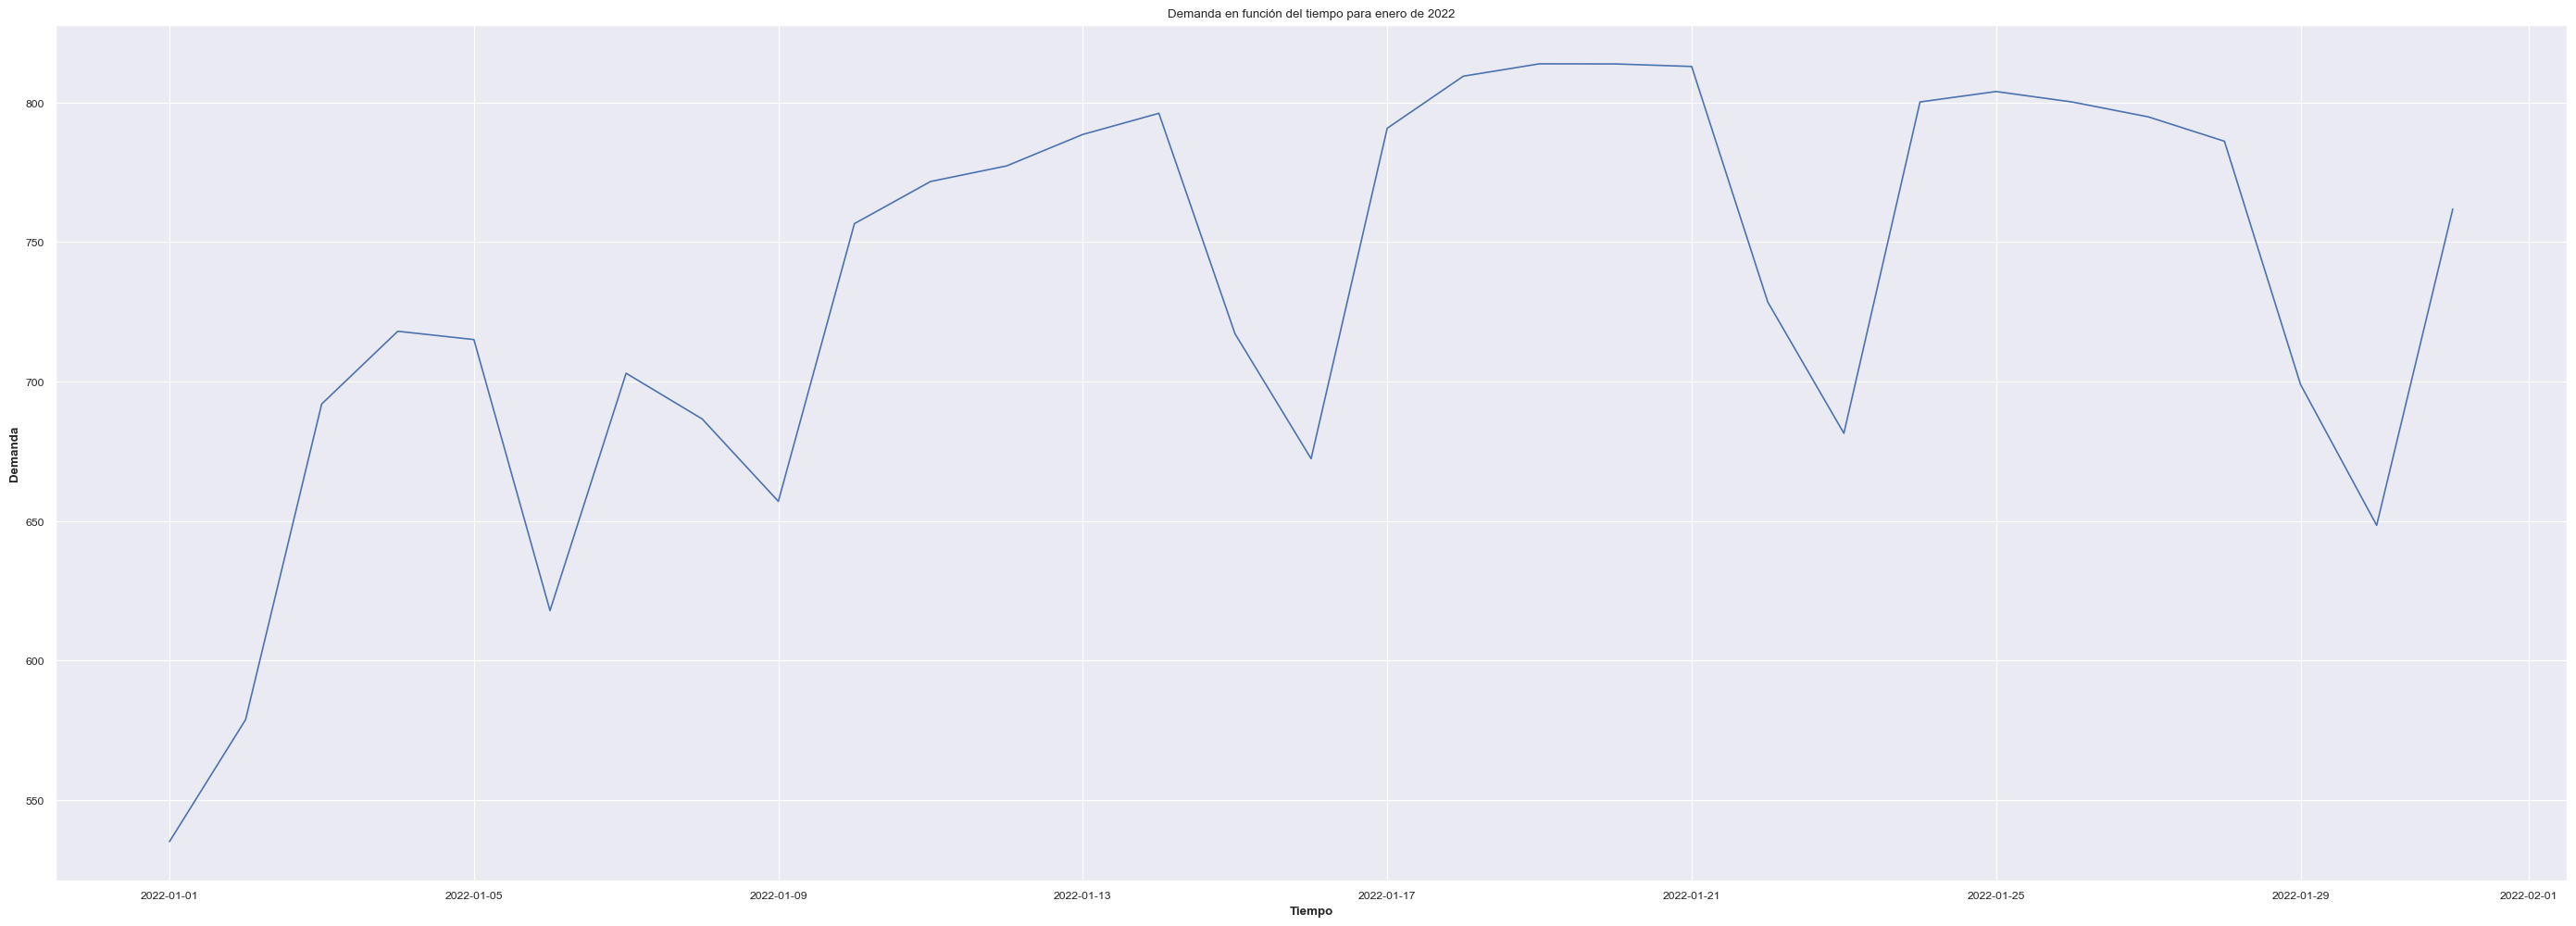

In [570]:
sns.set_style("darkgrid")
fig = plt.figure(figsize=(35, 12))

# Filtrar el dataframe para el mes de enero de 2022
mes_filtrado = demanda[(demanda['Fecha'].dt.year == 2022) & (demanda['Fecha'].dt.month == 1)]

sns.lineplot(x=mes_filtrado['Fecha'], y=mes_filtrado['Demanda'])

plt.title('Demanda en función del tiempo para enero de 2022')
plt.xlabel('Tiempo')
plt.ylabel('Demanda')

plt.show()



## PlotSeries

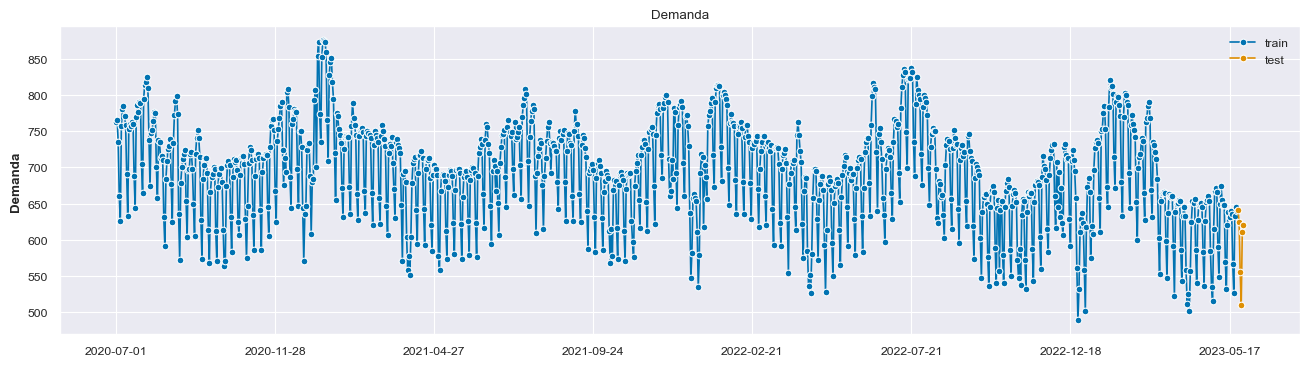

In [571]:
data_de = demanda.copy()
data_de = data_de[(['Fecha','Demanda'])]
data_de = data_de.set_index('Fecha')

data_de_train = data_de.loc[:'2023-05-24']['Demanda'].to_period('d')
data_de_test = data_de.loc['2023-05-25':]['Demanda'].to_period('d')

plot_series(data_de_train, data_de_test, labels=["train", "test"])
plt.title('Demanda');

## Predicción de la demanda total diaria GW/H


#### ETS

In [572]:
from sktime.forecasting.ets import AutoETS

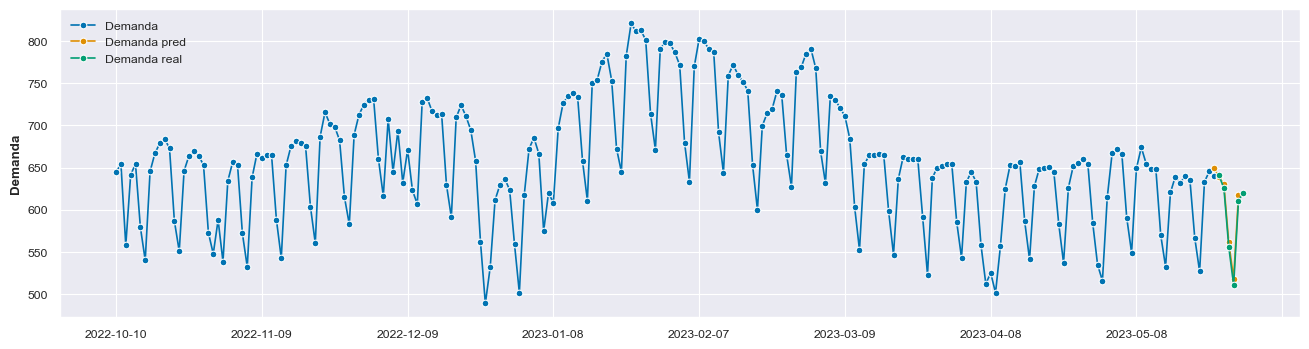

In [573]:
fh_ets = np.arange(0, 6)
ETS = AutoETS(auto=True, sp=7, n_jobs=-1)
ETS.fit(data_de_train)

ETS_pred = ETS.predict(fh_ets)

#destacar que hemos puesto sp de 14 ya que vemos ciclos bisemanales. Esto quiere decir que hay mas ventas cada dos semanas
fig, ax = plot_series(data_de_train['2022-10-10':], ETS_pred, data_de_test, labels=["Demanda", "Demanda pred", "Demanda real"])

ax.legend(loc='upper left');


In [574]:
ETS_pred

2023-05-24    649.448239
2023-05-25    638.978269
2023-05-26    630.034205
2023-05-27    561.479925
2023-05-28    518.458530
2023-05-29    617.351593
Freq: D, Name: Demanda, dtype: float64

In [575]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

MAPE_ETS = mean_absolute_percentage_error(data_de_test, ETS_pred)
MSE_ETS = mean_squared_error(data_de_test, ETS_pred)
RMSE_ETS = np.sqrt(MSE_ETS)

print("MAPE:", MAPE_ETS)
print("MSE:", MSE_ETS)
print("RMSE:", RMSE_ETS)


MAPE: 0.07048366455511575
MSE: 2792.8266611702916
RMSE: 52.847201072244985


Predicciones finales Demanda

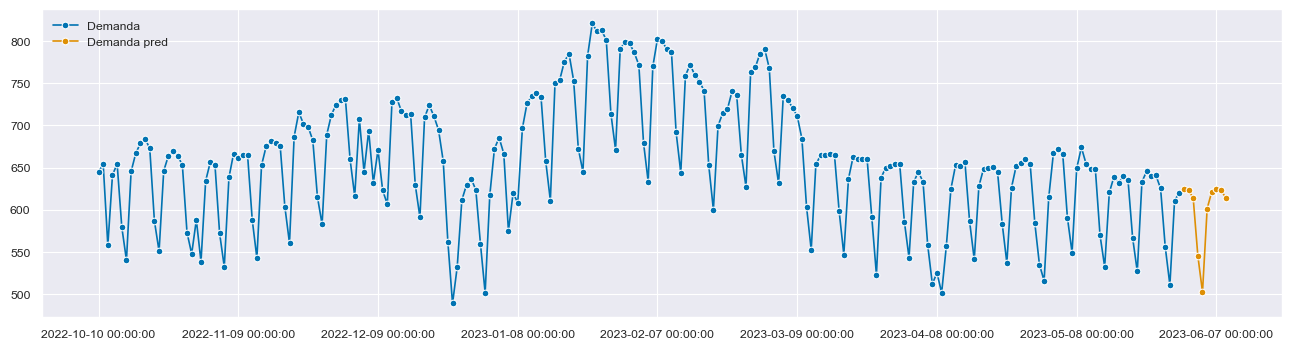

In [576]:
fh_ets = np.arange(1, 11)
ETS = AutoETS(auto=True, sp=7, n_jobs=-1)
ETS.fit(data_de)

ETS_pred = ETS.predict(fh_ets)

#destacar que hemos puesto sp de 14 ya que vemos ciclos bisemanales. Esto quiere decir que hay mas ventas cada dos semanas
fig, ax = plot_series(data_de['2022-10-10':], ETS_pred, labels=["Demanda", "Demanda pred"])

ax.legend(loc='upper left');


In [577]:
data_de_test

2023-05-25    640.728355
2023-05-26    625.457526
2023-05-27    556.141015
2023-05-28    510.928902
2023-05-29    610.504707
2023-05-30    620.514666
Freq: D, Name: Demanda, dtype: float64

In [578]:
ETS_pred  #añadir el día 30 2023-05-30    620.514666

Demanda
2023-05-31  624.767784
2023-06-01  623.109586
2023-06-02  614.138846
2023-06-03  545.606694
2023-06-04  502.577172
2023-06-05  601.494086
2023-06-06  621.627924
2023-06-07  624.767784
2023-06-08  623.109586
2023-06-09  614.138846

In [579]:
# Crear una nueva fila con la fecha '2023-05-30' y el valor dado
nueva_fila = pd.DataFrame({'Demanda': [620.514666]}, index=pd.to_datetime(['2023-05-30']))

# Concatenar la nueva fila al DataFrame existente
ETS_pred = pd.concat([nueva_fila, ETS_pred]).sort_index()

In [580]:


# Crear una nueva fila con los valores deseados
nueva_fila = {'Date': '2023-05-30', 'GasN_pred': 1.775996}

# Convertir la nueva fila en un DataFrame
nueva_df = pd.DataFrame(nueva_fila, index=[0])

# Concatenar la nueva fila al principio del DataFrame existente
gasn_pred_df = pd.concat([nueva_df, gasn_pred_df]).reset_index(drop=True)

# añadir el 30 donde el valor es 1.775996
gasn_pred_df

Date  GasN_pred
0            2023-05-30   1.775996
1   2023-05-31 00:00:00   2.805192
2   2023-06-01 00:00:00   2.061391
3   2023-06-02 00:00:00   1.999522
4   2023-06-03 00:00:00   1.976082
5   2023-06-04 00:00:00   2.064189
6   2023-06-05 00:00:00   2.243734
7   2023-06-06 00:00:00   2.354160
8   2023-06-07 00:00:00   2.332626
9   2023-06-08 00:00:00   2.402037
10  2023-06-09 00:00:00   2.464789

In [581]:
renovables_pred

Fecha  Hidráulica      Eólica       Solar  Otras renovables  \
1246 2023-05-31   56.701184  136.356825  138.255689          9.466501   
1247 2023-06-01   55.574051  140.505167  137.780534          9.530188   
1248 2023-06-02   54.135444  143.102506  138.817232          9.653081   
1249 2023-06-03   43.418605  134.873517  139.958295          9.649309   
1250 2023-06-04   37.121195  132.958959  140.242069          9.400750   
1251 2023-06-05   50.469984  141.122396  139.216105          9.315062   
1252 2023-06-06   55.099757  130.055159  138.307860          9.465616   
1253 2023-06-07   56.717961  120.270818  140.344034          9.519234   
1254 2023-06-08   55.435506  126.186242  140.449533          9.620559   
1255 2023-06-09   53.806696  130.737557  142.028906          9.779002   

      Residuos renovables  
1246             1.627453  
1247             1.652430  
1248             1.700328  
1249             1.745749  
1250             1.756550  
1251             1.743286  
1252             1.753773  
1253             1.782306  
1254             1.811635  
1255             1.862345

In [582]:
media_columnas = renovables_pred.mean()

# Crear una nueva fila con la fecha '2023-05-30' y los valores de la media
nueva_fila = pd.DataFrame(media_columnas).T
nueva_fila['Fecha'] = '2023-05-30'

# Concatenar la nueva fila al principio del DataFrame existente
renovables_pred = pd.concat([nueva_fila, renovables_pred]).reset_index(drop=True)


In [583]:
gasn_pred_df
uranio_pred
renovables_pred

Hidráulica      Eólica       Solar  Otras renovables  Residuos renovables  \
0    51.848038  133.616914  139.540026          9.539930             1.743586   
1    56.701184  136.356825  138.255689          9.466501             1.627453   
2    55.574051  140.505167  137.780534          9.530188             1.652430   
3    54.135444  143.102506  138.817232          9.653081             1.700328   
4    43.418605  134.873517  139.958295          9.649309             1.745749   
5    37.121195  132.958959  140.242069          9.400750             1.756550   
6    50.469984  141.122396  139.216105          9.315062             1.743286   
7    55.099757  130.055159  138.307860          9.465616             1.753773   
8    56.717961  120.270818  140.344034          9.519234             1.782306   
9    55.435506  126.186242  140.449533          9.620559             1.811635   
10   53.806696  130.737557  142.028906          9.779002             1.862345   

                  Fecha  
0            2023-05-30  
1   2023-05-31 00:00:00  
2   2023-06-01 00:00:00  
3   2023-06-02 00:00:00  
4   2023-06-03 00:00:00  
5   2023-06-04 00:00:00  
6   2023-06-05 00:00:00  
7   2023-06-06 00:00:00  
8   2023-06-07 00:00:00  
9   2023-06-08 00:00:00  
10  2023-06-09 00:00:00

# CO2

In [584]:
co2 = pd.read_csv("clean_data/co2_clean.csv")

In [585]:
co2['Date'] = pd.to_datetime(co2['Date'])  #convertimos a fecha

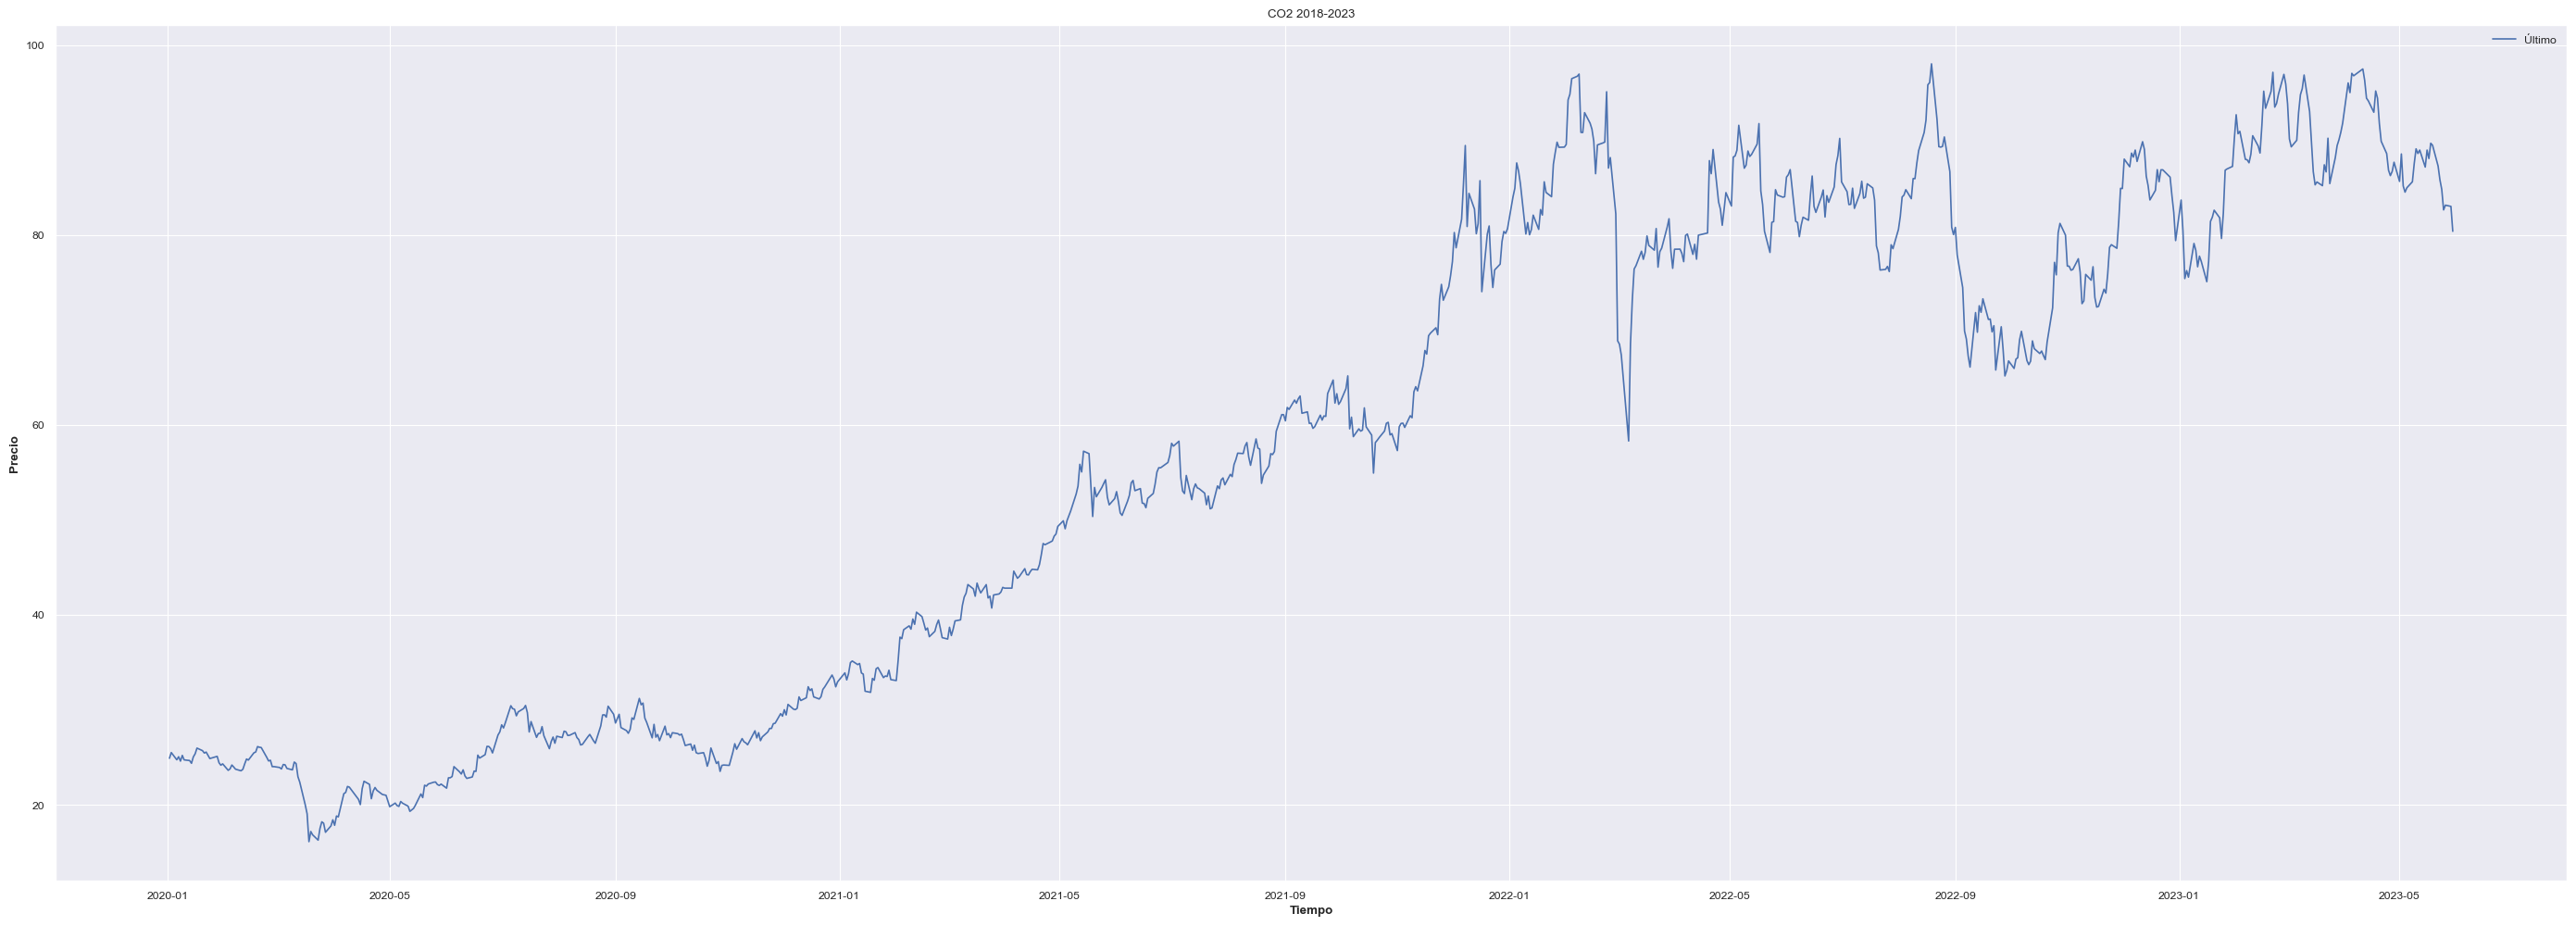

In [586]:
fig = plt.figure(figsize=(35,12))
sns.set_style("darkgrid")

sns.lineplot(x=co2.Date,y=co2['CO2'], data=co2['CO2'])

plt.title('CO2 2018-2023')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend(['Último'])

plt.show()

In [587]:
co2 = co2.set_index('Date')
date_range = pd.date_range(start=co2.index.min(), end=co2.index.max())
filled_co2 = pd.merge(pd.DataFrame(date_range, columns=['Date']), co2, how='left', left_on='Date', right_index=True)

filled_co2 = filled_co2.fillna(method='ffill')

filled_co2['year'] = filled_co2['Date'].dt.year
filled_co2['month'] = filled_co2['Date'].dt.month
filled_co2['day'] = filled_co2['Date'].dt.day



In [588]:
x = filled_co2.iloc[:, -3:].values  #input
y = filled_co2.iloc[:, 1].values #output price only

In [589]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=5,shuffle=False)

y_test

array([83.13, 83.13, 83.13, 83.  , 80.38])

### XGB Regressor

In [590]:
xgbr=XGBR()
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [591]:
y_pred=xgbr.predict(x_test)

mean_squared_error(y_test, y_pred, squared=False)  # RMSE

1.7423092884529048

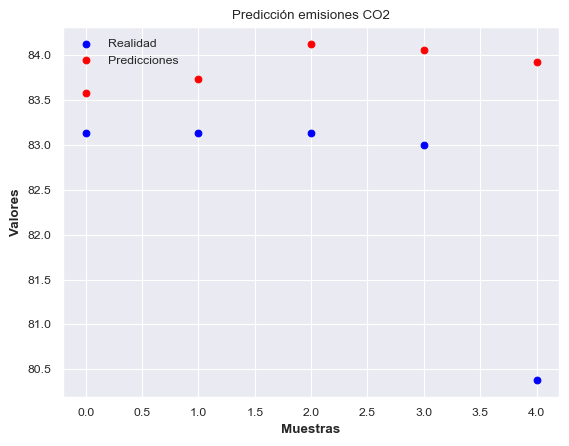

In [592]:
# gráfico de dispersión
plt.scatter(range(len(y_test)), y_test, color='blue', label='Realidad')
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicciones')
plt.xlabel('Muestras')
plt.ylabel('Valores')
plt.title('Predicción emisiones CO2')
plt.legend()
plt.show()

In [593]:
y_test

array([83.13, 83.13, 83.13, 83.  , 80.38])

Los próximos días

In [594]:
last_date = pd.to_datetime(filled_co2['Date'].iloc[-1])
next_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=10)
x_next_7_days = np.array([next_dates.year, next_dates.month, next_dates.day]).T
y_pred
co2_pred=xgbr.predict(x_next_7_days)
co2_pred = pd.DataFrame({'Date': next_dates, 'CO2_pred': co2_pred})
# Crear una nueva fila con los valores deseados
nueva_fila = {'Date': '2023-05-30', 'CO2_pred': 80.38}

# Convertir la nueva fila en un DataFrame
nueva_fila_df = pd.DataFrame(nueva_fila, index=[0])

# Concatenar la nueva fila al principio del DataFrame existente
co2_pred = pd.concat([nueva_fila_df, co2_pred]).reset_index(drop=True)


In [595]:
gasn_pred_df
co2_pred
renovables_pred
ETS_pred

Demanda
2023-05-30  620.514666
2023-05-31  624.767784
2023-06-01  623.109586
2023-06-02  614.138846
2023-06-03  545.606694
2023-06-04  502.577172
2023-06-05  601.494086
2023-06-06  621.627924
2023-06-07  624.767784
2023-06-08  623.109586
2023-06-09  614.138846

In [596]:
# Cambiar el nombre de la columna "Fecha" a "Date" en renovables_pred
renovables_pred = renovables_pred.rename(columns={'Fecha': 'Date'})

ETS_pred.reset_index(inplace=True)
ETS_pred = ETS_pred.rename(columns={'index': 'Date'})





In [597]:
renovables_pred

Hidráulica      Eólica       Solar  Otras renovables  Residuos renovables  \
0    51.848038  133.616914  139.540026          9.539930             1.743586   
1    56.701184  136.356825  138.255689          9.466501             1.627453   
2    55.574051  140.505167  137.780534          9.530188             1.652430   
3    54.135444  143.102506  138.817232          9.653081             1.700328   
4    43.418605  134.873517  139.958295          9.649309             1.745749   
5    37.121195  132.958959  140.242069          9.400750             1.756550   
6    50.469984  141.122396  139.216105          9.315062             1.743286   
7    55.099757  130.055159  138.307860          9.465616             1.753773   
8    56.717961  120.270818  140.344034          9.519234             1.782306   
9    55.435506  126.186242  140.449533          9.620559             1.811635   
10   53.806696  130.737557  142.028906          9.779002             1.862345   

                   Date  
0            2023-05-30  
1   2023-05-31 00:00:00  
2   2023-06-01 00:00:00  
3   2023-06-02 00:00:00  
4   2023-06-03 00:00:00  
5   2023-06-04 00:00:00  
6   2023-06-05 00:00:00  
7   2023-06-06 00:00:00  
8   2023-06-07 00:00:00  
9   2023-06-08 00:00:00  
10  2023-06-09 00:00:00

In [598]:
renovables_pred

Hidráulica      Eólica       Solar  Otras renovables  Residuos renovables  \
0    51.848038  133.616914  139.540026          9.539930             1.743586   
1    56.701184  136.356825  138.255689          9.466501             1.627453   
2    55.574051  140.505167  137.780534          9.530188             1.652430   
3    54.135444  143.102506  138.817232          9.653081             1.700328   
4    43.418605  134.873517  139.958295          9.649309             1.745749   
5    37.121195  132.958959  140.242069          9.400750             1.756550   
6    50.469984  141.122396  139.216105          9.315062             1.743286   
7    55.099757  130.055159  138.307860          9.465616             1.753773   
8    56.717961  120.270818  140.344034          9.519234             1.782306   
9    55.435506  126.186242  140.449533          9.620559             1.811635   
10   53.806696  130.737557  142.028906          9.779002             1.862345   

                   Date  
0            2023-05-30  
1   2023-05-31 00:00:00  
2   2023-06-01 00:00:00  
3   2023-06-02 00:00:00  
4   2023-06-03 00:00:00  
5   2023-06-04 00:00:00  
6   2023-06-05 00:00:00  
7   2023-06-06 00:00:00  
8   2023-06-07 00:00:00  
9   2023-06-08 00:00:00  
10  2023-06-09 00:00:00

In [599]:
uranio_pred

fecha    Precio
0 2023-06-02  3.120509
1 2023-06-03  3.119598
2 2023-06-04  3.117385
3 2023-06-05  3.116109
4 2023-06-06  3.117643
5 2023-06-07  3.120028
6 2023-06-08  3.106986
7 2023-06-09  3.092263

In [600]:
uranio_pred = uranio_pred.rename(columns={'fecha': 'Date', 'Precio': 'Uranio'})

In [601]:
media = uranio_pred['Uranio'].mean()
mediana = uranio_pred['Uranio'].median()

nuevas_filas = pd.DataFrame({'Date': ['2023-05-30', '2023-05-31', '2023-06-01'],
                            'Uranio': [media, mediana, uranio_pred['Uranio'].iloc[0]]})

uranio_pred = pd.concat([nuevas_filas, uranio_pred], ignore_index=True)





In [602]:
uranio_pred

Date    Uranio
0            2023-05-30  3.113815
1            2023-05-31  3.117514
2            2023-06-01  3.120509
3   2023-06-02 00:00:00  3.120509
4   2023-06-03 00:00:00  3.119598
5   2023-06-04 00:00:00  3.117385
6   2023-06-05 00:00:00  3.116109
7   2023-06-06 00:00:00  3.117643
8   2023-06-07 00:00:00  3.120028
9   2023-06-08 00:00:00  3.106986
10  2023-06-09 00:00:00  3.092263

In [603]:
uranio_pred['Date'] = pd.to_datetime(uranio_pred['Date'])

In [604]:
# Convertir la columna 'Date' a datetime en cada DataFrame
gasn_pred_df['Date'] = pd.to_datetime(gasn_pred_df['Date'])
co2_pred['Date'] = pd.to_datetime(co2_pred['Date'])
renovables_pred['Date'] = pd.to_datetime(renovables_pred['Date'])
ETS_pred['Date'] = pd.to_datetime(ETS_pred['Date'])

# Combinar los DataFrames a través de la columna "Date"
preds = gasn_pred_df.merge(co2_pred, on='Date').merge(renovables_pred, on='Date').merge(ETS_pred, on='Date')


In [605]:
preds = preds.merge(uranio_pred, on='Date')

In [606]:
preds

Date  GasN_pred   CO2_pred  Hidráulica      Eólica       Solar  \
0  2023-05-30   1.775996  80.380000   51.848038  133.616914  139.540026   
1  2023-05-31   2.805192  85.363213   56.701184  136.356825  138.255689   
2  2023-06-01   2.061391  86.732559   55.574051  140.505167  137.780534   
3  2023-06-02   1.999522  90.320534   54.135444  143.102506  138.817232   
4  2023-06-03   1.976082  86.561127   43.418605  134.873517  139.958295   
5  2023-06-04   2.064189  85.209923   37.121195  132.958959  140.242069   
6  2023-06-05   2.243734  85.112457   50.469984  141.122396  139.216105   
7  2023-06-06   2.354160  81.178329   55.099757  130.055159  138.307860   
8  2023-06-07   2.332626  81.032890   56.717961  120.270818  140.344034   
9  2023-06-08   2.402037  80.699417   55.435506  126.186242  140.449533   
10 2023-06-09   2.464789  84.470428   53.806696  130.737557  142.028906   

    Otras renovables  Residuos renovables     Demanda    Uranio  
0           9.539930             1.743586  620.514666  3.113815  
1           9.466501             1.627453  624.767784  3.117514  
2           9.530188             1.652430  623.109586  3.120509  
3           9.653081             1.700328  614.138846  3.120509  
4           9.649309             1.745749  545.606694  3.119598  
5           9.400750             1.756550  502.577172  3.117385  
6           9.315062             1.743286  601.494086  3.116109  
7           9.465616             1.753773  621.627924  3.117643  
8           9.519234             1.782306  624.767784  3.120028  
9           9.620559             1.811635  623.109586  3.106986  
10          9.779002             1.862345  614.138846  3.092263

In [608]:
#preds.to_csv('preds.csv', index=False)